# Social Graphs and Interactions 2022

## Final Assignment

The topic of our Final Assignment is <em>Spotify artist recommendation network analysis</em>. We want to analyse the correlation between the top 1000 artists and their recommendation system, as well as find how they form communities and what is the sentiment of their songs.

### Data collection

The first step of our project was data collection. We downloaded the <em>Music artists popularity</em> from [Kaggle](https://www.kaggle.com/datasets/pieca111/music-artists-popularity).

In [3]:
# import libraries

import requests
import base64
import time
import networkx as nx
import numpy as np
import pandas as pd
import spotipy
import string
import nltk
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import colorsys
import random
import powerlaw

from fa2 import ForceAtlas2
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords  # from nltk
from spacy.lang.en.stop_words import STOP_WORDS #from spacy
from langdetect import detect
from lyricsgenius import Genius
from collections import Counter
from ast import literal_eval
from spotipy.oauth2 import SpotifyClientCredentials
from community import community_louvain
from matplotlib.lines import Line2D

# values have been removed due to it being personal data.
SPOTIPY_CLIENT_ID = '' 
SPOTIPY_CLIENT_SECRET = '' 

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET))

In [ ]:
artists_csv = pd.read_csv("artists.csv.zip", low_memory=False)

In [ ]:
print(artists_csv.head())

artists_csv = artists_csv[artists_csv['ambiguous_artist'] == False][[
    'artist_mb', 'country_mb', 'scrobbles_lastfm']]

                                   mbid              artist_mb  \
0  cc197bad-dc9c-440d-a5b5-d52ba2e14234               Coldplay   
1  a74b1b7f-71a5-4011-9441-d0b5e4122711              Radiohead   
2  8bfac288-ccc5-448d-9573-c33ea2aa5c30  Red Hot Chili Peppers   
3  73e5e69d-3554-40d8-8516-00cb38737a1c                Rihanna   
4  b95ce3ff-3d05-4e87-9e01-c97b66af13d4                 Eminem   

           artist_lastfm      country_mb           country_lastfm  \
0               Coldplay  United Kingdom           United Kingdom   
1              Radiohead  United Kingdom           United Kingdom   
2  Red Hot Chili Peppers   United States            United States   
3                Rihanna   United States  Barbados; United States   
4                 Eminem   United States            United States   

                                             tags_mb  \
0  rock; pop; alternative rock; british; uk; brit...   
1  rock; electronic; alternative rock; british; g...   
2  rock; alternative

The dataset contains information about around 1.4 milion artists from MusicBrainz and Last.fm. The information includes artist name, genrees and listeners/scrobbles on last.fm.

We want to take the top 1000 artists. We didn't choose more artists, because we realised that we might end up gathering too many artists, who we have never heard of (hardly anyone listens to more than 1000 artists in their lifetime). Even the sites like <em>Rolling Stones</em> usually chooses only top 100 artists of all the time. Moreover, the number is enough to show some interesting statistics about the dataset and offers a variety of artits in terms of genres etc.

In [ ]:
top_artists = artists_csv.sort_values(
    by=['scrobbles_lastfm'], ascending=False).head(1000)

print(top_artists.head())
print(top_artists.shape[0])

         artist_mb      country_mb  scrobbles_lastfm
17     The Beatles  United Kingdom       517126254.0
1        Radiohead  United Kingdom       499548797.0
0         Coldplay  United Kingdom       360111850.0
8             Muse  United Kingdom       344838631.0
23  Arctic Monkeys  United Kingdom       332306552.0
1000


Now, we are going to use the [Spotify API](https://developer.spotify.com/documentation/web-api/) to gather the artists' Spotify IDs, needed for later data collection.

In [ ]:
def find_artist_id_and_spotify_name(artist_name):
    query_artist = artist_name.replace(' ', '+')

    artist_id = None
    artist_mb = None

    try:
        result = spotify.search(q=query_artist, type='artist', limit=1)
        artist = result['artists']['items'][0]

        artist_spotify_url = artist['external_urls']['spotify']
        artist_id = artist_spotify_url.split('/')[-1]
        artist_name = artist['name']
    except Exception as e:
        print(artist_name)
        print(e)
        return artist_id, artist_name
    
    return artist_id, artist_name
    

top_artists['artist_spotify_id'], top_artists['artist_mb'] = zip(
    *top_artists['artist_mb'].map(
        lambda artist_name: find_artist_id_and_spotify_name(
            artist_name)))

We are going to drop the artists who do not appear on Spotify. Moreover, a few artists' names occur several times on the list. We are going to take the one with the most Last.fm scrobbles only.

In [ ]:
# dropping the artists whose data is not in Spotify API
top_artists = top_artists[~top_artists['artist_spotify_id'].isna()]
top_artists = top_artists[~top_artists['artist_mb'].isna()]

# dropping artists with duplicate names (and taking the most popular one)
top_artists = top_artists.drop_duplicates(subset=['artist_mb'], keep='first')

In [ ]:
print(top_artists.shape[0])
print(top_artists.head())

Next, we are gathering the info from Spotify about the genres.

In [ ]:
def get_genre(artist_id):
    genres = []

    try:
        result = spotify.artist(artist_id)
        genres =  result['genres']
    except Exception as e:
        print(e)
        return genres

    return genres

top_artists['genre'] = top_artists['artist_spotify_id'].map(
    lambda artist_id: get_genre(
        artist_id))

Now, we are gathering the <em>relatd artists</em>, so the main link condition of our network.

In [ ]:
def find_related_artists(artist_id):
    url = f'https://api.spotify.com/v1/artists/{artist_id}/related-artists'
    
    names = []

    try:
        result = spotify.artist_related_artists(artist_id)

        for artist in result['artists']:
            names.append(artist['name'])
    except Exception as e:
        print(e)
        return names
    
    return names

top_artists['related_artists'] = top_artists['artist_spotify_id'].map(lambda artist_id:
    find_related_artists(artist_id))

Last but not least, we are gathering the song names of top tracks for each artis. Every artist has up to 5 songs (can be fewer). We are going to use these tracks to analyse the sentiment later on.

In [ ]:
def get_popular_track_names(art_id):
    tracks = spotify.artist_top_tracks(art_id)
    return [track['name'] for track in tracks['tracks']]

top_artists['track_names'] = top_artists['artist_spotify_id'].map(lambda artist_id:
    get_popular_track_names(artist_id))

When obtaining lyrics from Genius API, we process the text with lemmatizer, as well as remove stop words and punctuation. Songs not in english are not evaluated, hence if detected language is not english, we remove an empty list. Otherwise, the lyrics for each track are saved as a list of tokens.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

# client secret removed - personal data
genius = Genius('')
genius.remove_section_headers = True
genius.skip_non_songs = True
genius.verbose = False

stop = set(stopwords.words('english') + list(string.punctuation) + ['embed'])

def tokenize(lyrics):
    tokens = nltk.word_tokenize(lyrics)
    words = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalnum() and word not in stop]
    return words

def get_genius_lyrics(song_list, artist, i):
    if i >= len(song_list):
        return None
    song_tokens = None
    z = 0
    while z < 10:
        try:
            song = genius.search_song(song_list[i], artist, get_full_info=False)
            if not song or not song.lyrics or not detect(song.lyrics) == 'en':
                song_tokens = []
            else:
                song_tokens = tokenize(song.lyrics)
            break
        except:
            z += 1
            pass
    return song_tokens

In [ ]:
#top_artists = pd.read_csv('final1000/top_artists.csv')
for i in range(0, 5):
    col_name = 'track_' + str(i)
    top_artists[col_name] = top_artists.apply(
        lambda x:get_genius_lyrics(x['track_names'], x['artist_mb'], i), axis=1)


### Network creation

Finally, we are going to create the recommendation network. There is a link from artist1 to artist2, if artist2 is in <em>Fans also like</em> of artist1. The attributes of the nodes are: country, genre and popularity (number of scrobbles on Last.fm).

In [7]:
artists_network = nx.DiGraph()
all_artists = top_artists['artist_mb'].tolist()

for idx, row in top_artists.iterrows():
    for related_artist in row['related_artists']:
        if related_artist in all_artists:
            if not artists_network.has_edge(row['artist_mb'], related_artist):
                artists_network.add_edge(row['artist_mb'], related_artist)
    if not artists_network.has_node(row['artist_mb']):
        artists_network.add_node(row['artist_mb'])
    try:
        artists_network.nodes[row['artist_mb']]['country'] = row['country_mb']
        artists_network.nodes[row['artist_mb']]['genre'] = str(row['genre'])
        artists_network.nodes[row['artist_mb']]['popularity'] = row['scrobbles_lastfm']
    except Exception as e:
        print(e)
        print(row['artist_mb'])
        print(artists_network.nodes[row['artist_mb']])

    

We saved and read from files (both the network and artists, due to the fact that data collection took a long time

In [ ]:
# save the data as csv and gml
top_artists.to_csv('final1000/top_artists.csv')
nx.write_gml(artists_network, 'final1000/artists_network.gml')

In [12]:
print(artists_network.number_of_nodes())
print(artists_network.number_of_edges())

992
5421


In [10]:
#top_artists.to_csv('final1000/top_artists.csv')
top_artists = pd.read_csv('final1000/top_artists.csv')

A small demonstration for Lady Gaga node.

In [13]:
print([neigh for neigh in artists_network.neighbors("Lady Gaga")])
print(artists_network.nodes["Lady Gaga"])

['Katy Perry', 'Tove Lo', 'Ellie Goulding', 'Selena Gomez & The Scene', 'Jessie J', 'Gwen Stefani', 'P!nk', 'Charli XCX', 'MARINA', 'Demi Lovato', 'Fergie', 'Sia', 'Selena Gomez', 'Avril Lavigne', 'Britney Spears', 'Iggy Azalea', 'Christina Aguilera', 'Azealia Banks']
{'country': 'United States', 'genre': ['art pop', 'dance pop', 'pop'], 'popularity': 285469647.0}


### Data statistics

In [ ]:
top_artists = pd.read_csv('final1000/top_artists.csv')

First, we are going to download the network from a file and parse the string lists to python lists.

In [9]:
artists_network = nx.read_gml('final1000/artists_network.gml')

# converting string list to list
genres_list = dict([(node, literal_eval(genres)) for node, genres in nx.get_node_attributes(
    artists_network, 'genre').items()])
nx.set_node_attributes(artists_network, genres_list, 'genre')

In [ ]:
print('Number of nodes: ', artists_network.number_of_nodes())
print('Number of edges: ', artists_network.number_of_edges())

Number of nodes:  992
Number of edges:  5421


Our network has 992 nodes and 5421 edges.

Now, we are going to plot the degree distributions of our network

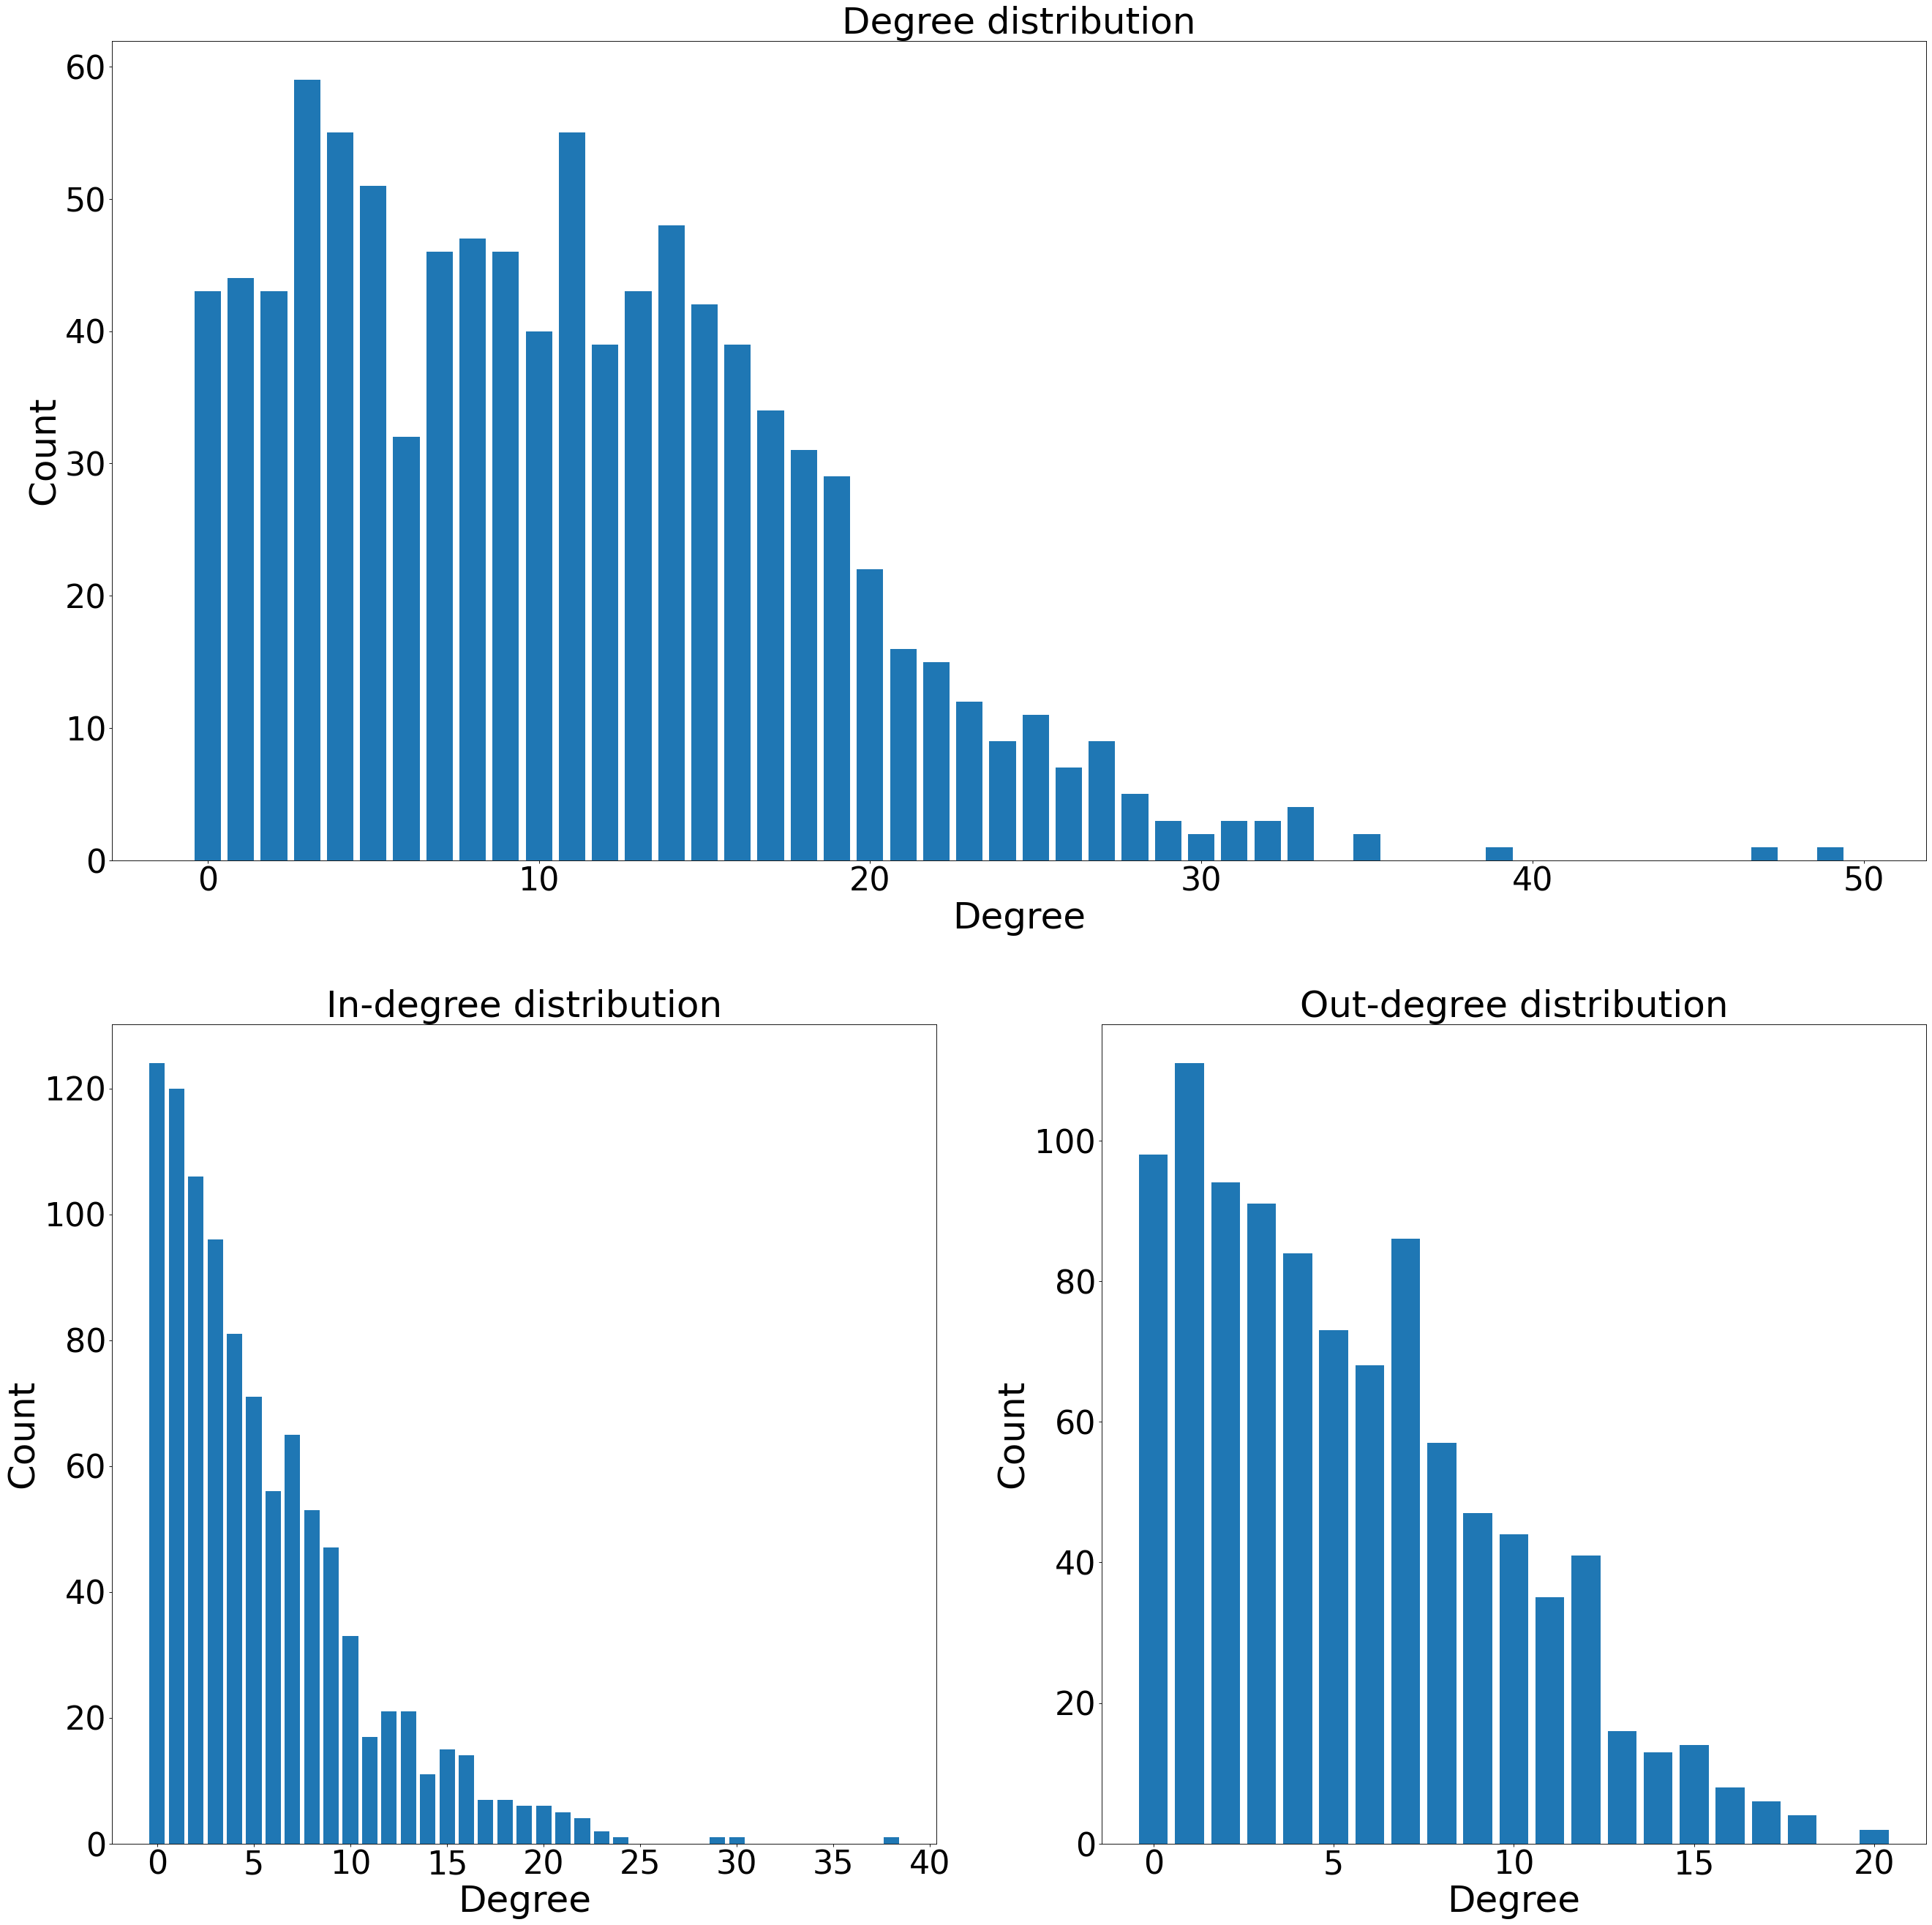

In [14]:
plt.figure(figsize=(40, 40), dpi=80)

# total degree distribution

degree_sequence = sorted((d for n, d in artists_network.degree()))

v = [*range(np.amin(degree_sequence), np.amax(degree_sequence) + 1)]
degree_distribution = np.histogram(degree_sequence,
                        bins=np.amax(degree_sequence) - np.amin(degree_sequence) + 1)

plt.subplot(2, 1, 1)
plt.bar(v, degree_distribution[0])
plt.xlabel('Degree', fontsize=45)
plt.ylabel('Count', fontsize=45)
plt.title('Degree distribution', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

# in and out degree distributions

in_degree_sequence = sorted((d for n, d in artists_network.in_degree()))
out_degree_sequence = sorted((d for n, d in artists_network.out_degree()))

v_in = [*range(np.amin(in_degree_sequence), np.amax(in_degree_sequence) + 1)]
in_degree_distribution = np.histogram(in_degree_sequence,
                        bins=np.amax(in_degree_sequence) - np.amin(in_degree_sequence) + 1)

v_out = [*range(np.amin(out_degree_sequence), np.amax(out_degree_sequence) + 1)]
out_degree_distribution = np.histogram(out_degree_sequence,
                        bins=np.amax(out_degree_sequence) - np.amin(out_degree_sequence) + 1)

plt.subplot(2, 2, 3)
plt.bar(v_in, in_degree_distribution[0])
plt.xlabel('Degree', fontsize=45)
plt.ylabel('Count', fontsize=45)
plt.title('In-degree distribution', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.subplot(2, 2, 4)
plt.bar(v_out, out_degree_distribution[0])
plt.xlabel('Degree', fontsize=45)
plt.ylabel('Count', fontsize=45)
plt.title('Out-degree distribution', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

plt.show()


Now, we want to see who are the top 5 most connected artists (for total, in- and out-degree).

In [15]:
# in degree

in_degree_sorted = sorted([(n, d) for (n, d) in artists_network.in_degree()],
key=lambda x: x[1], reverse=True)

top_5_in_artists = in_degree_sorted[0:5]

print('Top 5 artists (in degree):', ', '.join(
    [f'({n}: {d})' for (n, d) in top_5_in_artists]))

# out degree

out_degree_sorted = sorted([(n, d) for (n, d) in artists_network.out_degree()],
key=lambda x: x[1], reverse=True)

top_5_out_artists = out_degree_sorted[0:5]

print('Top 5 artists (out degree):', ', '.join(
    [f'({n}: {d})' for (n, d) in top_5_out_artists]))

# total degree

degree_sorted = sorted([(n, d) for (n, d) in artists_network.degree()],
    key=lambda x: x[1], reverse=True)

top_5_artists = degree_sorted[0:5]

print('Top 5 connected artists:', ', '.join(
    [f'({n}: {d})' for (n, d) in top_5_artists]))


Top 5 artists (in degree): (Broken Social Scene: 38), (TV On The Radio: 30), (Grizzly Bear: 29), (Deerhunter: 24), (Passion Pit: 23)
Top 5 artists (out degree): (Radiohead: 20), (Arcade Fire: 20), (The Killers: 18), (Linkin Park: 18), (Lady Gaga: 18)
Top 5 connected artists: (Broken Social Scene: 49), (TV On The Radio: 47), (Grizzly Bear: 39), (Broken Bells: 35), (Passion Pit: 35)


Since, the distributions resamble these of a random network, we check by fitting the powerlaw distribution.

In [16]:
powerlaw_alfa = powerlaw.Fit(degree_sequence).alpha
powerlaw_in_alfa = powerlaw.Fit(in_degree_sequence).alpha
powerlaw_out_alfa = powerlaw.Fit(out_degree_sequence).alpha

print('Powerlaw alfa for the whole graph: ', powerlaw_alfa)
print('Powerlaw alfa for in: ', powerlaw_in_alfa)
print('Powerlaw alfa for out: ', powerlaw_out_alfa)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Powerlaw alfa for the whole graph:  8.160533449436006
Powerlaw alfa for in:  8.535419160911903
Powerlaw alfa for out:  8.736103476881045
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Now, we are going to investigate how many unique countries we have in our dataset.

In [17]:
countries_old = nx.get_node_attributes(artists_network, 'country').values()
countries_old = ['None' if pd.isna(country) else country for country in countries_old]
countries_counts_old = Counter(countries_old)

df_c_old = pd.DataFrame.from_dict(countries_counts_old, orient='index')
df_c_old.columns = ['count']
print('All unique countries: ', df_c_old.shape[0])

df_c_old = df_c_old.sort_values(by=['count'], ascending=False)

All unique countries:  30


We have decided to narrow that number down. We are going to take the top 15 countries and put the rest in <em>Other</em> category.

In [18]:
def get_general_country(country):
    if country not in ["United States", "United Kingdom", "Canada", "Sweden", "Germany", "Australia"]:
        return "Other"
    return country

general_countries_list = dict([(node, get_general_country(country)) for node, country in nx.get_node_attributes(
    artists_network, 'country').items()])
nx.set_node_attributes(artists_network, general_countries_list, 'country')

We did the same for the genres. First, we calculate the number of unique values.

In [19]:
lists_of_genres_old = nx.get_node_attributes(artists_network, 'genre').values()
all_genres_old = [genre for list_of_genres in lists_of_genres_old for genre in list_of_genres]
genres_counts_old = Counter(all_genres_old)

df_g_old = pd.DataFrame.from_dict(genres_counts_old, orient='index')
df_g_old.columns = ['count']
print('All unique genres: ', df_g_old.shape[0])

df_g_old = df_g_old.sort_values(by=['count'], ascending=False)

All unique genres:  815


Next, we take the top 9 most generic genres there are anad label the rest as <em>Other</em>. We assign a label <em>pop</em> to artist, if at least one of their tags has word </em>pop</em> in them. We put the 

In [20]:
def check_if_genre_exists(genres, sought_genre):
    for genre in genres:
        if sought_genre in genre:
            return True
    return False

def get_general_genre(genres):
    if check_if_genre_exists(genres, "hip hop"):
        return "hip hop"
    elif check_if_genre_exists(genres, "rap"):
        return "rap"
    elif check_if_genre_exists(genres, "electro"):
        return "electro"
    elif check_if_genre_exists(genres, "punk"):
        return "punk"
    elif check_if_genre_exists(genres, "indie"):
        return "indie"
    elif check_if_genre_exists(genres, "metal"):
        return "metal"
    elif check_if_genre_exists(genres, "pop"):
        return "pop"
    elif check_if_genre_exists(genres, "rock"):
        return "rock"
    return "other"

general_genres_list = dict([(node, get_general_genre(genres)) for node, genres in nx.get_node_attributes(
    artists_network, 'genre').items()])
nx.set_node_attributes(artists_network, general_genres_list, 'genre')

Now, we plot the histograms of genres and countries before and after the aggregation. 

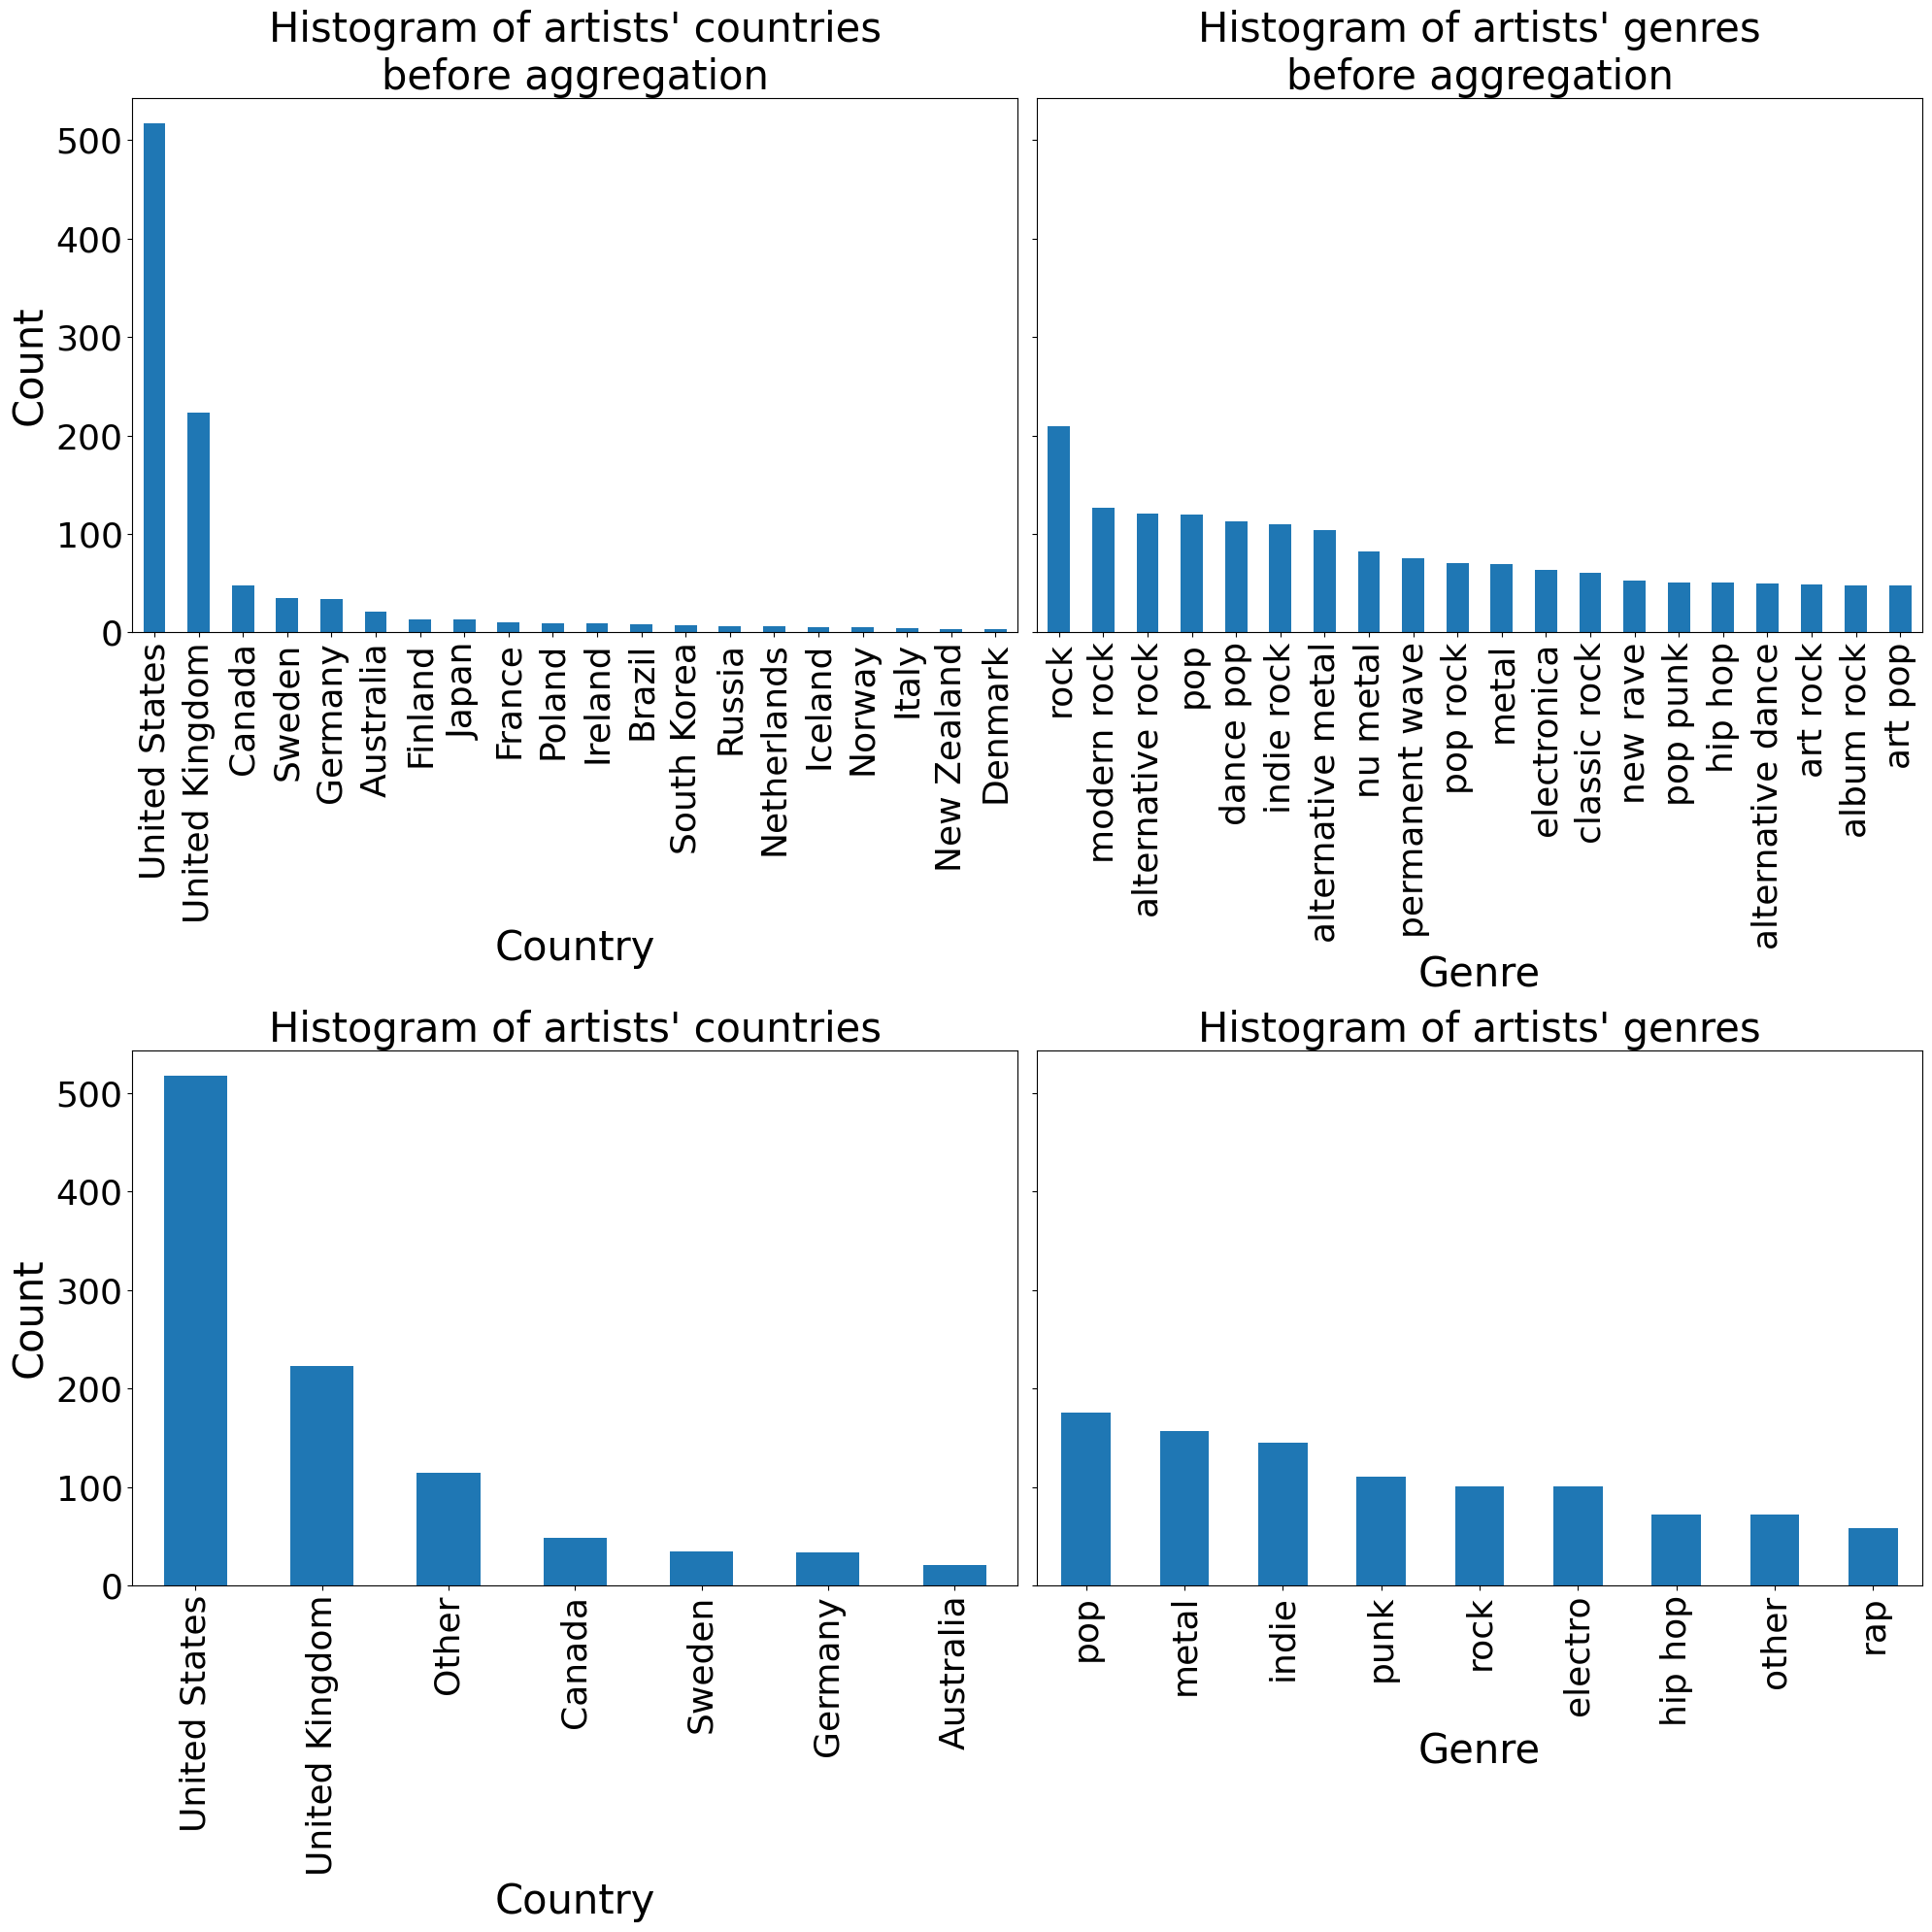

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 25), sharey=True)

# old countries

df_c_old.head(20).plot(kind='bar', figsize=(20, 20), legend=False, ax=ax1)
ax1.set_title('Histogram of artists\' countries\nbefore aggregation', fontsize=30)
ax1.set_xlabel('Country', fontsize=30)
ax1.set_ylabel('Count', fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=26)

# old genres

df_g_old.head(20).plot(kind='bar', figsize=(20, 20), legend=False, ax=ax2)
ax2.set_title('Histogram of artists\' genres\nbefore aggregation', fontsize=30)
ax2.set_xlabel('Genre', fontsize=30)
ax2.set_ylabel('Count', fontsize=30)
ax2.tick_params(axis='both', which='major', labelsize=26)

# new countries

countries = nx.get_node_attributes(artists_network, 'country').values()
countries = ['None' if pd.isna(country) else country for country in countries]
countries_counts = Counter(countries)
df = pd.DataFrame.from_dict(countries_counts, orient='index')
df.columns = ['count']
df = df.sort_values(by=['count'], ascending=False)

df.plot(kind='bar', figsize=(20, 20), legend=False, ax=ax3)
ax3.set_title('Histogram of artists\' countries', fontsize=30)
ax3.set_xlabel('Country', fontsize=30)
ax3.set_ylabel('Count', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=26)

# new genres

genres = nx.get_node_attributes(artists_network, 'genre').values()
genres_counts = Counter(genres)
df = pd.DataFrame.from_dict(genres_counts, orient='index')
df.columns = ['count']
df = df.sort_values(by=['count'], ascending=False)

df.plot(kind='bar', figsize=(20, 20), legend=False, ax=ax4)
ax4.set_title('Histogram of artists\' genres', fontsize=30)
ax4.set_xlabel('Genre', fontsize=30)
ax4.set_ylabel('Count', fontsize=30)
ax4.tick_params(axis='both', which='major', labelsize=26)

fig.tight_layout()

plt.show()

### Visualizing the network

Now, we are going to visualize the network we created in the previous steps. First, we will look at the configuration, where size depends on the artist's popularity and node color depends on the country of origin.

In [22]:
undirected_artists = artists_network.to_undirected()

largest_cc = max(nx.connected_components(undirected_artists), key=len)

undirected_artists_largest_cc = undirected_artists.subgraph(largest_cc).copy()

color_map_countries = []
size_map_countries = []

# to normalize the size of the nodes

popularities = list(nx.get_node_attributes(artists_network, 'popularity').values())

d_min = np.amin(popularities)
d_max = np.amax(popularities)

borders = {'actual': {'lower': d_min, 'upper': d_max}, 'desired': {'lower': 5, 'upper': 300}}
           
def normalize(value, bounds):
    return bounds['desired']['lower'] + (value - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower'])

countries = list(set(nx.get_node_attributes(artists_network, 'country').values()))

# declaring the colormap

N = len(countries)

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, N))

def cmap(n):
    return colors[n]

# asssigning the node sizes and node colors for countries

for node in undirected_artists_largest_cc.nodes():
    color_index = countries.index(undirected_artists_largest_cc.nodes[node]["country"])
    color_map_countries.append(cmap(color_index))
    size_map_countries.append(normalize(
        undirected_artists_largest_cc.nodes[node]["popularity"], borders))

We calculate the positions and visualize the network using ForceAtlas2 algorithm.

In [23]:
# initializing the ForceAtlas2 algorithm

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=False,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.01,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

# calculate network positions

positions = forceatlas2.forceatlas2_networkx_layout(undirected_artists_largest_cc,
    pos=None, iterations=2000)

# create legend for countries

legend_elements_countries = []
for i, country in enumerate(countries):
    legend_elements_countries.append(
        Line2D([0], [0], marker='o', color='w', label=country, markerfacecolor=cmap(i),
            markersize=15))

100%|██████████| 2000/2000 [00:06<00:00, 309.93it/s]Repulsion forces  took  5.24  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.13  seconds
AdjustSpeedAndApplyForces step  took  0.57  seconds



In [24]:
color_map_genres = []
size_map_genres = []

# asssigning the node sizes and node colors for genres

genres = list(set(nx.get_node_attributes(artists_network, 'genre').values()))

N = len(genres)

colors = plt.cm.rainbow(np.linspace(0, 1, N))

for node in undirected_artists_largest_cc.nodes():
    color_index = genres.index(undirected_artists_largest_cc.nodes[node]["genre"])
    color_map_genres.append(cmap(color_index))
    size_map_genres.append(normalize(undirected_artists_largest_cc.nodes[node]["popularity"],
        borders))

# create legend for genres

legend_elements_genres = []
for i, genre in enumerate(genres):
    legend_elements_genres.append(
        Line2D([0], [0], marker='o', color='w', label=genre, markerfacecolor=cmap(i), markersize=15))

Lastly, we will plot the graphs next to each other. We will take the largest connected component.

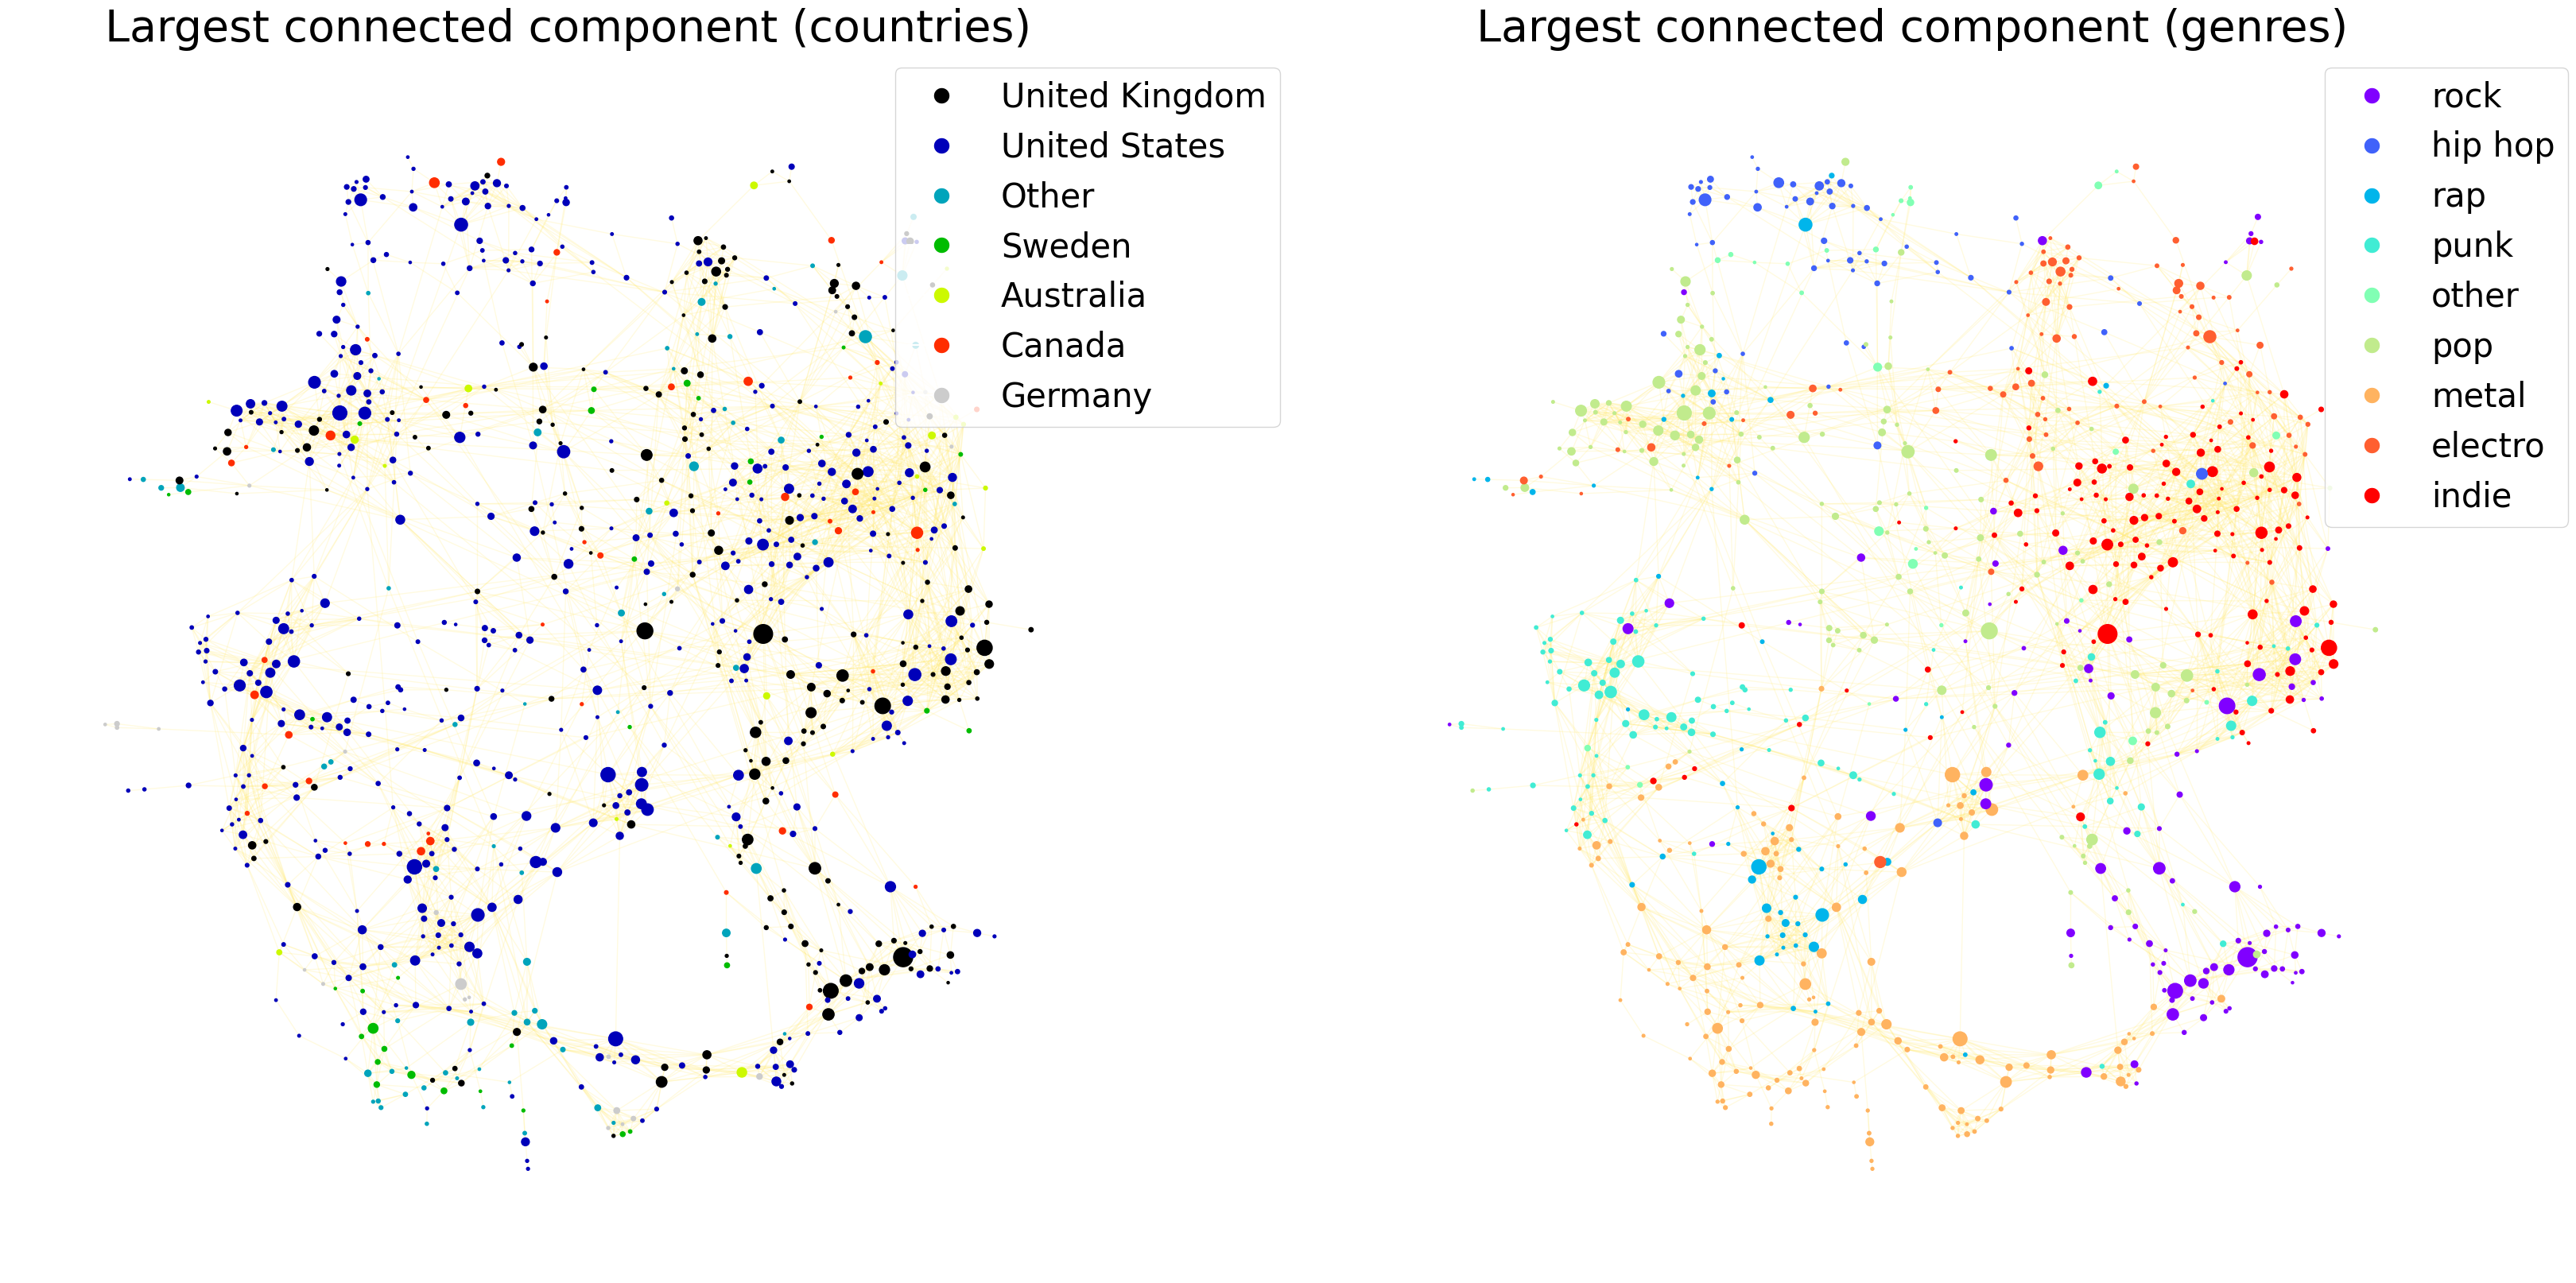

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

# countries

nx.draw_networkx_nodes(undirected_artists_largest_cc, positions, node_size=size_map_countries,
    node_color=color_map_countries, ax=ax1)
nx.draw_networkx_edges(undirected_artists_largest_cc, positions, edge_color="#FFEA68",
    alpha=0.2, ax=ax1)
ax1.axis('off')
ax1.set_title('Largest connected component (countries)', fontsize=40)
ax1.legend(handles=legend_elements_countries, loc='upper right', prop={'size': 30},
    fontsize=25, bbox_to_anchor=(1.15, 1))

# genres

nx.draw_networkx_nodes(undirected_artists_largest_cc, positions, node_size=size_map_genres,
    node_color=color_map_genres, ax=ax2)
nx.draw_networkx_edges(undirected_artists_largest_cc, positions, edge_color="#FFEA68",
    alpha=0.2, ax=ax2)
ax2.axis('off')
ax2.set_title('Largest connected component (genres)', fontsize=40)
ax2.legend(handles=legend_elements_genres, loc='upper right', prop={'size': 30},
    fontsize=25, bbox_to_anchor=(1.1, 1))

plt.show()

### Community detection

In this section, we will look into the communities formed in our network. First we will look at the simple divisions based on the country of the artist and the genre, to see if they create good community structures.

First, we will look at the countries.

In [26]:
# working on undirected version of the network

artists_network_undirected = artists_network.to_undirected()

L = artists_network_undirected.number_of_edges()
Ls = {}
ks = {}

unique_countries = np.unique([country for country in general_countries_list.values()])

for country in unique_countries:
    Ls[country] = 0
    ks[country] = 0

for edge in artists_network_undirected.edges():
    for country in unique_countries:
        if artists_network_undirected.nodes[edge[0]]['country'] == country and\
         artists_network_undirected.nodes[edge[1]]['country'] == country:
            Ls[country] += 1

for node in artists_network_undirected.nodes():
    for country in unique_countries:
        if artists_network_undirected.nodes[node]['country'] == country:
            ks[country] += 1

modularities = {}

for country in unique_countries:
    modularities[country] = Ls[country] / L - (ks[country] / (2 * L))**2
    print('Modularity ', country, ': ', modularities[country])

artists_network_modularity = np.sum([modularity for modularity in modularities.values()])
print('Modularity: ', artists_network_modularity)

Modularity  Australia :  0.001170914927064381
Modularity  Canada :  0.006559417791822273
Modularity  Germany :  0.003985868169711414
Modularity  Other :  0.01771072728143254
Modularity  Sweden :  0.005868151424310454
Modularity  United Kingdom :  0.14055399893513643
Modularity  United States :  0.4277941890678143
Modularity:  0.6036432675972918


Now, we will calculate modularity for genres and compare with countries.

In [27]:
Ls = {}
ks = {}

unique_genres = np.unique([genre for genre in general_genres_list.values()])

for genre in unique_genres:
    Ls[genre] = 0
    ks[genre] = 0

for edge in artists_network_undirected.edges():
    for genre in unique_genres:
        if artists_network_undirected.nodes[edge[0]]['genre'] == genre and\
         artists_network_undirected.nodes[edge[1]]['genre'] == genre:
            Ls[genre] += 1

for node in artists_network_undirected.nodes():
    for genre in unique_genres:
        if artists_network_undirected.nodes[node]['genre'] == genre:
            ks[genre] += 1

modularities = {}

for genre in unique_genres:
    modularities[genre] = Ls[genre] / L - (ks[genre] / (2 * L))**2
    print('Modularity ', genre, ': ', modularities[genre])

artists_network_modularity_genres = np.sum([modularity for modularity in modularities.values()])
print('Modularity: ', artists_network_modularity_genres)

Modularity  electro :  0.07000933584343225
Modularity  hip hop :  0.04088863353442497
Modularity  indie :  0.14307030438163434
Modularity  metal :  0.11524232019233156
Modularity  other :  0.010521401896006893
Modularity  pop :  0.09020174775944191
Modularity  punk :  0.08222408196523633
Modularity  rap :  0.0322038664035097
Modularity  rock :  0.043408582547763704
Modularity:  0.6277702745237816


Both structures give similar modularity, so we want to see if we can achieve better communities with Louvain algorithms.

In [28]:
partition = community_louvain.best_partition(artists_network_undirected)
max_group = max(partition.values())

ks = [0] * max_group
Ls = [0] * max_group
for (artist, group) in partition.items():
    ks[group - 1] += artists_network_undirected.degree[artist]
    Ls[group - 1] += len(artists_network_undirected.edges(artist))

L = artists_network_undirected.number_of_edges()
modularity = 0
for i in range (1, max_group + 1):
    Ls[i - 1] /= 2
    modularity += Ls[i - 1] / L - (ks[i - 1] / (2 * L))**2

print('Modularity: ', modularity)

Modularity:  0.9012375603363589


We can see, that the modularity is around 0.9, which indicated a very good match.

Now, we will check the communities and their sizes.

In [29]:
# sorting the communities on their size

grouped_communities = Counter(partition.values())
grouped_communities_sorted = sorted(grouped_communities.items(), key=lambda k: k[1],
    reverse=True)

print('Numer of all communities: ', len(grouped_communities_sorted))

print('Communities: ')

for community, count in grouped_communities_sorted:
    community_members = []
    for artists_communities in partition.items():
        if artists_communities[1] == community:
            community_members.append(artists_communities[0])
    print("Community ", community, ': ', community_members)

Numer of all communities:  71
Communities: 
Community  4 :  ['Pixies', 'The Flaming Lips', 'Elliott Smith', 'Neutral Milk Hotel', 'Pavement', 'The Lumineers', 'Hozier', 'MGMT', 'Daft Punk', 'Justice', 'Digitalism', 'Ratatat', 'Metronomy', 'Empire of the Sun', 'The Avalanches', 'Hot Chip', 'Arcade Fire', 'The National', 'Yeah Yeah Yeahs', 'LCD Soundsystem', 'TV On The Radio', 'Broken Bells', 'Spoon', 'Grizzly Bear', 'Clap Your Hands Say Yeah', 'Wolf Parade', 'Broken Social Scene', 'Beirut', 'Vampire Weekend', 'London Grammar', 'The xx', 'Regina Spektor', 'Of Monsters and Men', 'The Drums', 'Foster The People', 'Death Cab for Cutie', 'The Shins', 'Modest Mouse', 'The Decemberists', 'The Postal Service', 'Silversun Pickups', 'Bright Eyes', 'Band of Horses', 'Rilo Kiley', 'Okkervil River', 'The Walkmen', 'The Antlers', 'Fleet Foxes', 'The War On Drugs', 'alt-J', 'Warpaint', 'The Whitest Boy Alive', 'Miike Snow', 'The Naked And Famous', 'Cold War Kids', 'Sufjan Stevens', 'Iron & Wine', 'Ani

We plot the counts for top 20 communities, since we can see that after that the groups are with only 1 person.

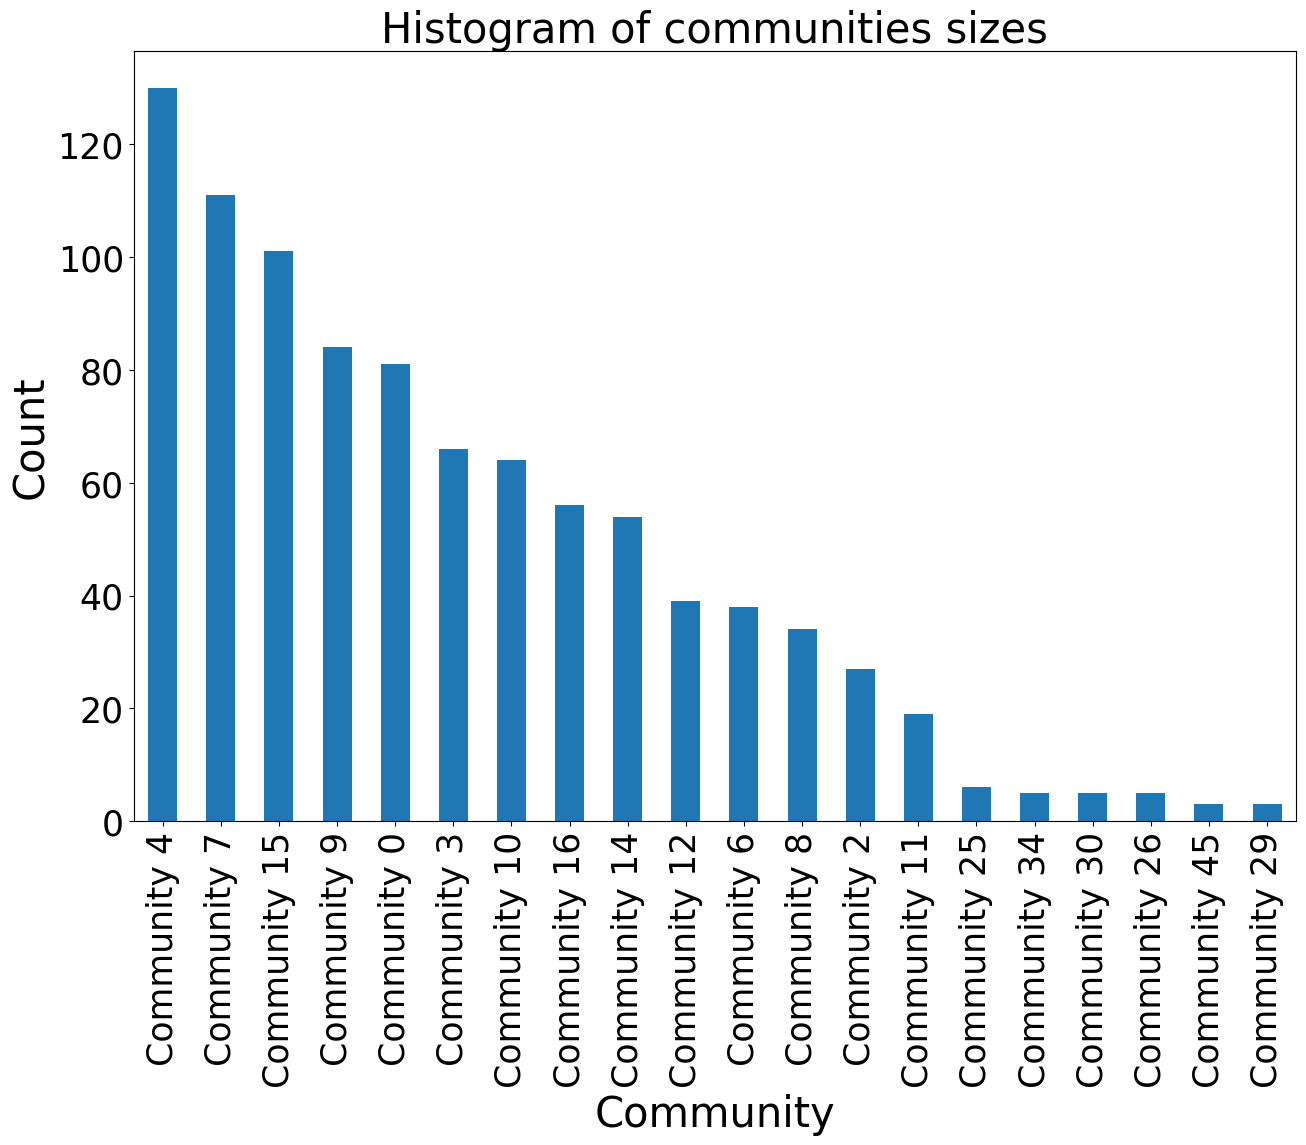

In [30]:
df_communities = pd.DataFrame.from_dict(grouped_communities, orient='index')
df_communities.columns = ['count']
df_communities = df_communities.sort_values(by=['count'], ascending=False)[0:20]

fig, ax = plt.subplots()

df_communities.plot(kind='bar', figsize=(15,10), legend=False, ax=ax)
ax.set_title('Histogram of communities sizes', fontsize=30)
ax.set_xlabel('Community', fontsize=30)
ax.set_ylabel('Count', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)

# change labels to write Community X

labels = ["Community " + item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.show()

Now, we want to see to what degree the communities match, the genre structure. First, we are going to take only top 13 communities and group the rest as <em>Community rest<em>.

In [31]:
top_13_communities = [item[0] for item in grouped_communities_sorted][0:13]

new_partition = dict()

for (artist, group) in partition.items():
    if group in top_13_communities:
        group_index = top_13_communities.index(group)
        new_partition[artist] = "Community " + str(group_index)
    else:
        new_partition[artist] = "Community rest"

partition = new_partition

Now, we are going to visualize the networks of all 9 genres and plot the node size based on the degree and color based on the community.

In [32]:
networks = []
size_maps = []
color_maps = []

communities = list(set(partition.values()))

N = len(communities)

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, N))

# assigning node sizes and colors for each genre network

for genre in unique_genres:
    nodes_network = [n for n in artists_network_undirected.nodes if \
        artists_network_undirected.nodes[n]["genre"] == genre]
    genre_network = artists_network_undirected.subgraph(nodes_network)

    color_map_genre = []
    size_map_genre = []

    degrees = [degree for node, degree in genre_network.degree()]

    d_min = np.amin(degrees)
    d_max = np.amax(degrees)

    borders = {'actual': {'lower': d_min, 'upper': d_max}, 'desired': {'lower': 5, 'upper': 300}}

    for artist in genre_network.nodes():
        group = partition[artist]
        group_index = communities.index(group)
        color_map_genre.append(cmap(group_index))
        size_map_genre.append(normalize(genre_network.degree(artist), borders))
    networks.append(genre_network)
    size_maps.append(size_map_genre)
    color_maps.append(color_map_genre)

100%|██████████| 2000/2000 [00:00<00:00, 11181.07it/s]
Repulsion forces  took  0.06  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds
100%|██████████| 2000/2000 [00:00<00:00, 15429.48it/s]
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds
100%|██████████| 2000/2000 [00:00<00:00, 6203.64it/s]
Repulsion forces  took  0.14  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds
100%|██████████| 2000/2000 [00:00<00:00, 5821.16it/s]
Repulsion forces  took  0.15  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds
100%|██████████| 2000/2000 [00:00<00:00, 16064.50it/s]
Repulsion forces  took  0.03  seconds
Gravi

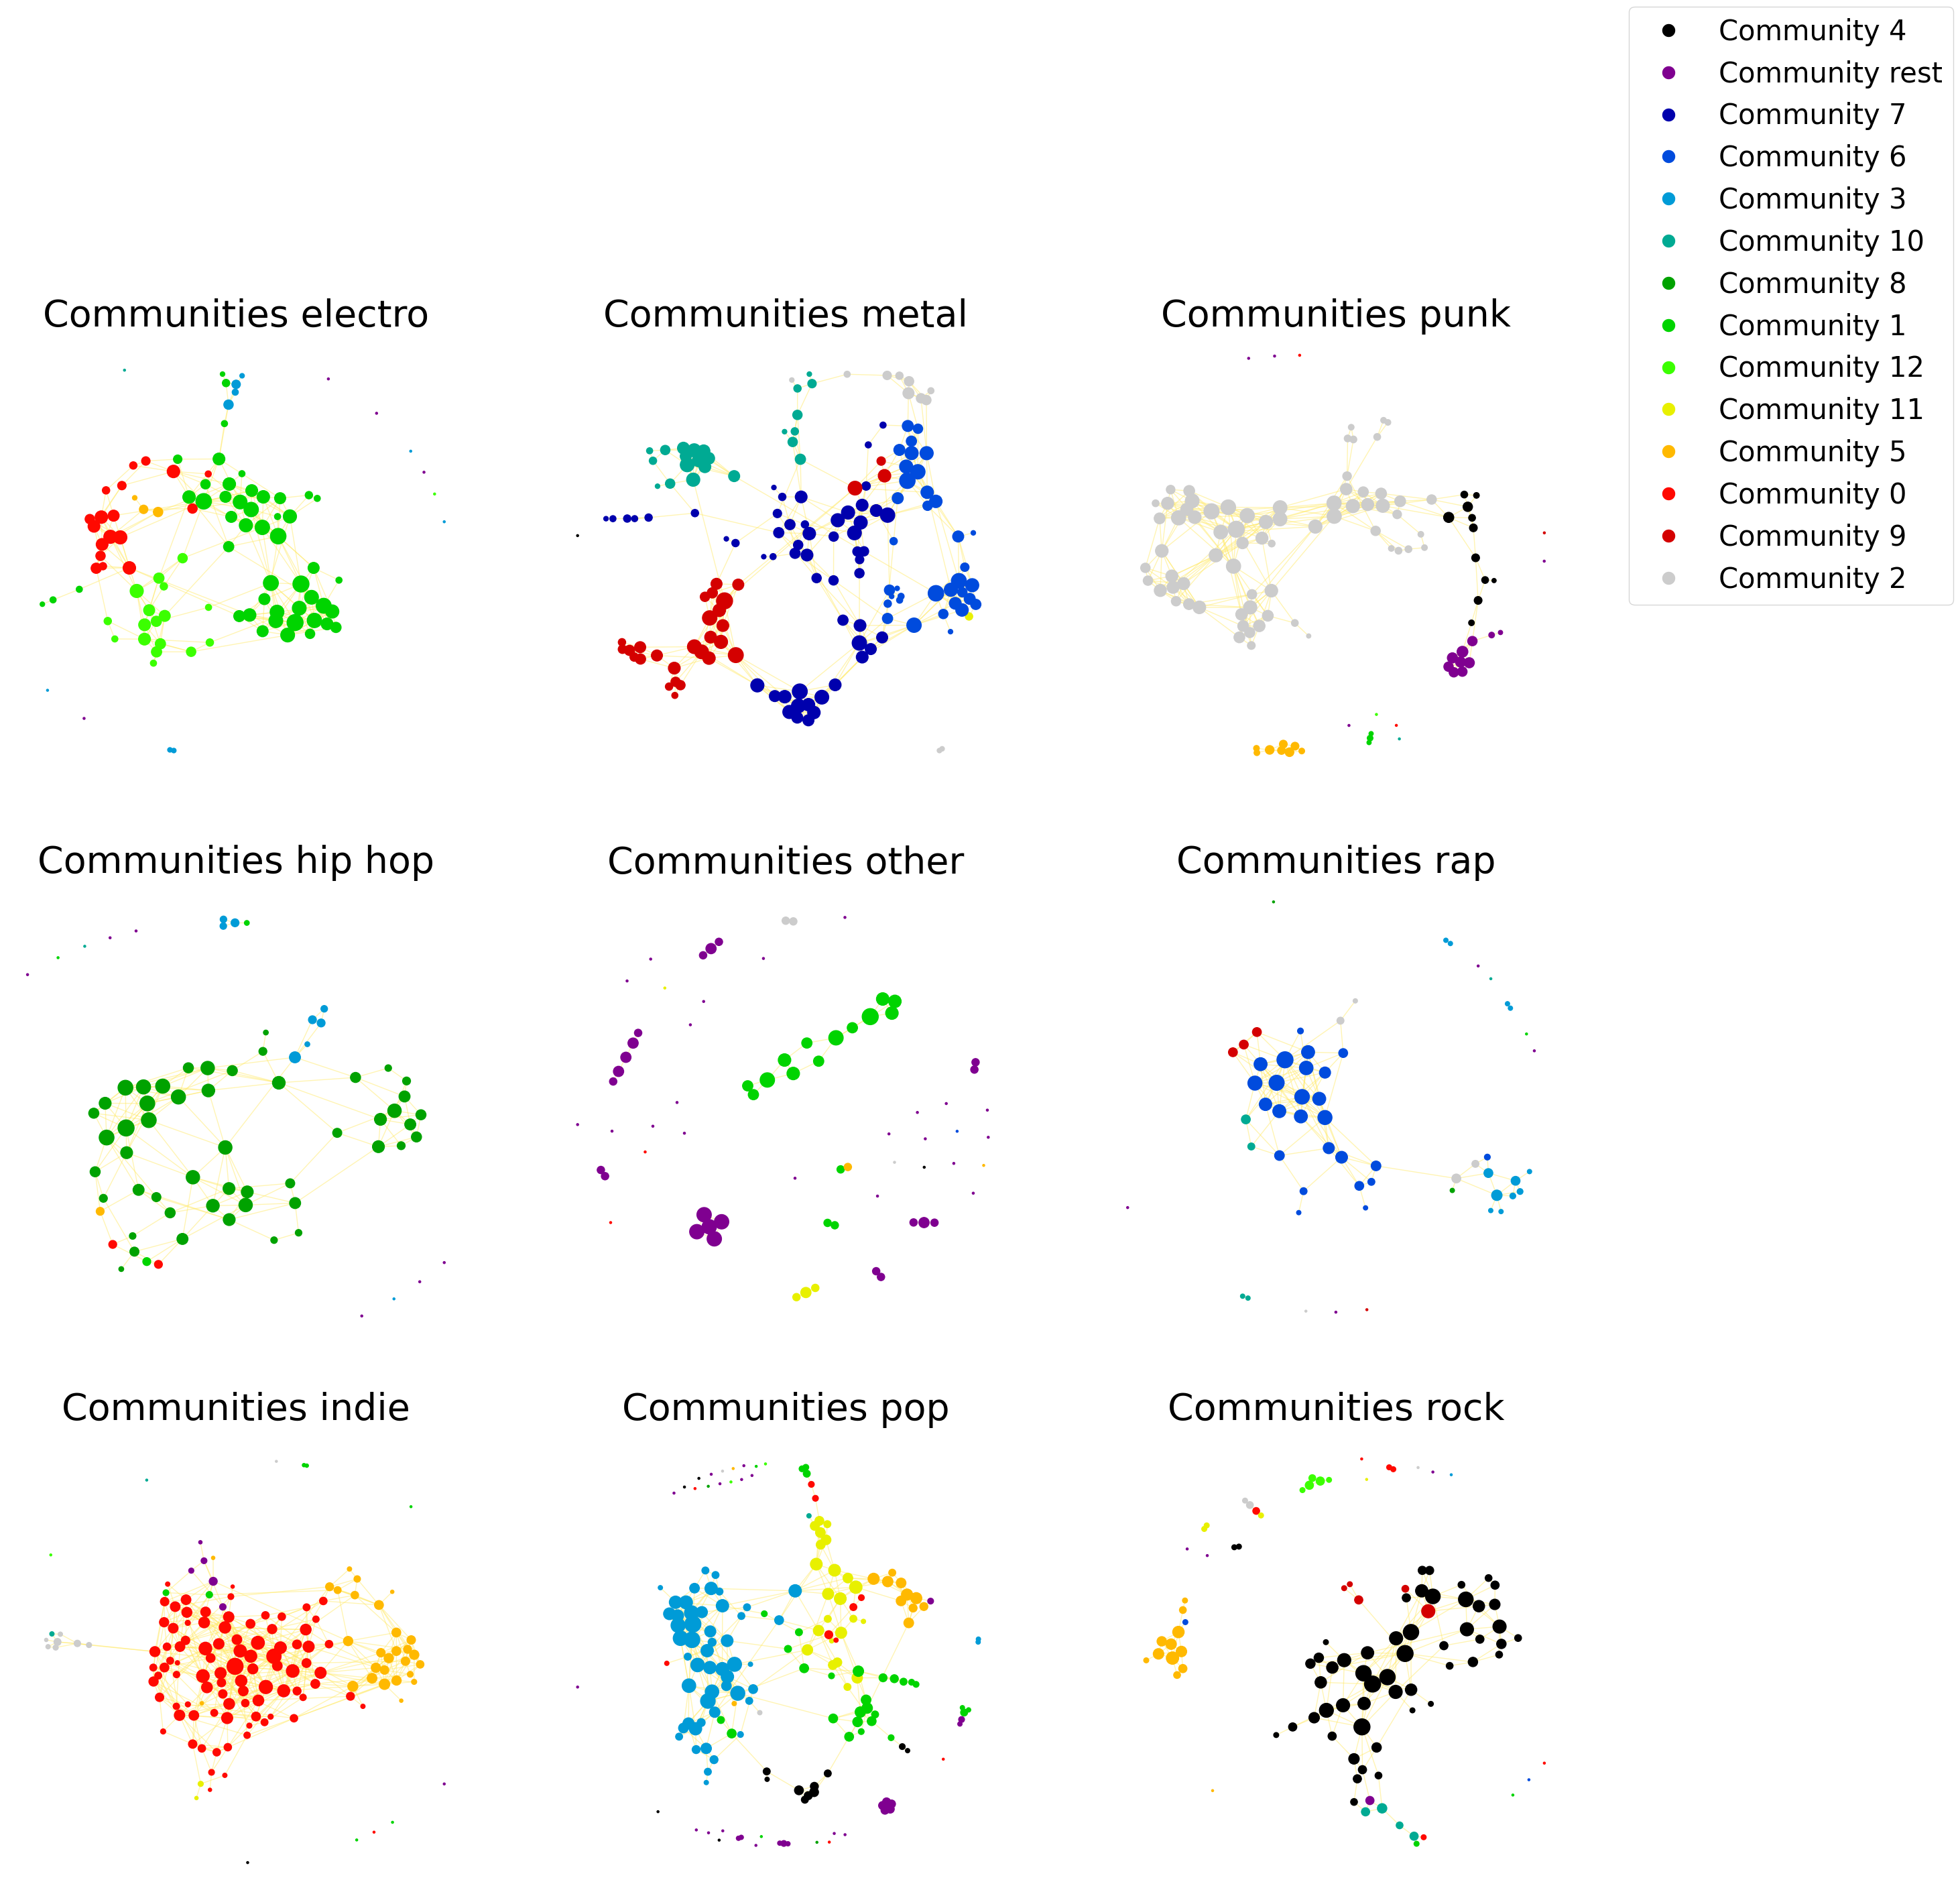

In [33]:
positions = []

# calculating positions for each genre network

for network in networks:
    positions_genre = forceatlas2.forceatlas2_networkx_layout(network, pos=None, iterations=2000)
    positions.append(positions_genre)

# plotting the genres networks and the communities

fig, axes = plt.subplots(3, 3, figsize=(30, 30))

ax_i = 0
ax_j = 0

for i, position in enumerate(positions):
    nx.draw_networkx_nodes(networks[i], position, node_size=size_maps[i], node_color=color_maps[i],
        ax=axes[ax_i, ax_j])
    nx.draw_networkx_edges(networks[i], position, edge_color="#FFEA68", alpha=0.5,
        ax=axes[ax_i, ax_j])
    axes[ax_i, ax_j].axis('off')
    axes[ax_i, ax_j].set_title('Communities ' + unique_genres[i], fontsize=40)
    ax_i += 1
    if ax_i == 3:
        ax_i = 0
        ax_j += 1

legend_elements = []
for i, community in enumerate(communities):
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', label=community, markerfacecolor=cmap(i),
            markersize=15))

fig.legend(handles=legend_elements, loc='upper right', prop={'size': 30},
    bbox_to_anchor=(1.1, 1.05))

plt.show()

### Sentiment

The LabMT word list is downloaded to calculate the sentiment. The list assigns happiness value to a set of words based on feelings associated with them, coming from a university study. From that list, the words and `happiness_average` value are put together into a dictionary.

Sentiment of a set of tokens is calculated by adding the happiness value for all the tokens, and then calculating a mean by dividing the sum by the token list length.

In [36]:
import csv,io,requests
import numpy as np
import pandas as pd
top = top_artists #pd.read_csv('final1000/top_artists.csv')
'''
Calculate sentiment for a set of tokens
'''
def sentiment(tokens, dictionary):
    return np.sum([dictionary[word] for word in tokens if word in dictionary.keys()])/len(tokens)

reader = csv.reader(io.StringIO(requests.get('https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001').text), delimiter='\t')
word_list = [word for word in reader] # Couldn't call list(reader) due to previous variable assignment
sentiment_dictionary = {}
for word in word_list[4:]: #removing the headers
    sentiment_dictionary[word[0]] = float(word[2]) #iterating over each word and adding it with happines_average


For the 5 tracks, we create dictionaries holding the reference to the artist name and the lyrics of the track. Then, they are combined into a dictionary where each artist is the key, and value is a list of tokens containing all 5 tracks lyrics. The artists that do not have any words in the token list are dropped. This may be due to the songs not being in English, or the lyrics not being available.

Finally, we calculate the mean sentiment for each artist and save it to `sentiment_artist_dict` dictionary. 

In [37]:
track_0_dict= dict(zip(top['artist_mb'], top['track_0']))
track_1_dict= dict(zip(top['artist_mb'], top['track_1']))
track_2_dict= dict(zip(top['artist_mb'], top['track_2']))
track_3_dict= dict(zip(top['artist_mb'], top['track_3']))
track_4_dict= dict(zip(top['artist_mb'], top['track_4']))
# doing literal_eval above was throwing an error
track_0_dict = {k: literal_eval(v) for k, v in track_0_dict.items()}
track_1_dict = {k: literal_eval(v) for k, v in track_1_dict.items()}
track_2_dict = {k: literal_eval(v) for k, v in track_2_dict.items()}
track_3_dict = {k: literal_eval(v) for k, v in track_3_dict.items()}
track_4_dict = {k: literal_eval(v) for k, v in track_4_dict.items()}

tracks_dict = {k: track_0_dict[k] + track_1_dict[k] + track_2_dict[k] + track_3_dict[k] + track_4_dict[k] for k in track_0_dict.keys()}
tracks_dict = {k: v for k,v in tracks_dict.items() if len(v) > 0}
sentiment_artists_dict = { k: sentiment(v, sentiment_dictionary) for k,v in tracks_dict.items() }

We calculate the mean, 10th and 90th percent value for all artists, and then create a dictionary with mean sentiment values for each of the genres we described earlier.

In [38]:
sentiment_all = [sentiment(tracks_dict[c], sentiment_dictionary) for c in artists_network.nodes if c in tracks_dict.keys()]
sentiment_all_mean = np.mean(sentiment_all)
sentiment_alll_90p = np.percentile(sentiment_all, 90)
sentiment_alll_10p = np.percentile(sentiment_all, 10)

genre_sentiment_mean = {genre: np.mean([sentiment_artists_dict[c]]) for genre in unique_genres for c in artists_network_undirected.nodes if artists_network_undirected.nodes[c]["genre"] == genre and c in sentiment_artists_dict.keys() }


We visualize the artist sentiment value with a histogram, markigall the mean genre values as well.

The mean sentiment value is 4.28
The 10th percentile sentiment value is 3.40
The 90th percentile sentiment value is 5.09
The mean sentiment value for electro is 5.04
The mean sentiment value for hip hop is 3.04
The mean sentiment value for indie is 4.33
The mean sentiment value for metal is 4.68
The mean sentiment value for other is 4.42
The mean sentiment value for pop is 2.85
The mean sentiment value for punk is 4.01
The mean sentiment value for rap is 5.57
The mean sentiment value for rock is 4.52


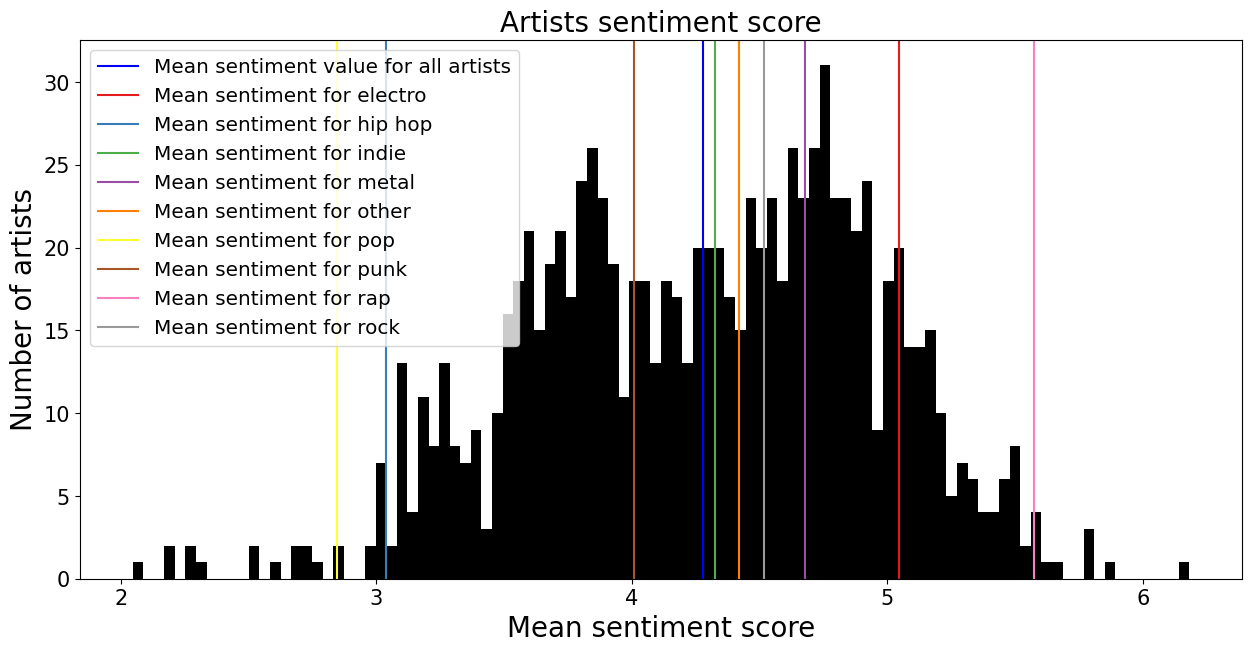

In [42]:
print(f'The mean sentiment value is {"%.2f" % sentiment_all_mean}')
print(f'The 10th percentile sentiment value is {"%.2f" % sentiment_alll_10p}')
print(f'The 90th percentile sentiment value is {"%.2f" % sentiment_alll_90p}')
cm = [a for a in plt.cm.get_cmap('Set1').colors]
plt.figure(figsize=(15,7), )
plt.hist(sentiment_all, bins=100,color='black', orientation='vertical')
plt.axvline(x=sentiment_all_mean,linestyle='-',color='b', label='Mean sentiment value for all artists')
for genre in unique_genres:
    print(f'The mean sentiment value for {genre} is {"%.2f" % genre_sentiment_mean[genre]}')
    plt.axvline(x=genre_sentiment_mean[genre],linestyle='-', color=cm[np.where(unique_genres == genre)[0][0]],label='Mean sentiment for '+genre)
plt.legend(fontsize="x-large")
plt.title("Artists sentiment score", fontsize=20)
plt.ylabel("Number of artists", fontsize=20)
plt.xlabel("Mean sentiment score", fontsize=20)
ax = plt.gca()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In order to see how neighboring nodes - connected artists differ in sentiment value in their songs, we calculated the difference in sentiment for all artists in `sentiment_artists_dict`. Mean, 90th and 10th percentile are also calculated. We can see that the difference between the neigboring artists in sentiment in on average, not big, making sense for the algorithm to recommend them.

/tmp/ipykernel_115/951386566.py:3: RuntimeWarning: Mean of empty slice
  neighb = np.nanmean([sentiment_artists_dict[a] for a in artists_network.neighbors(artist) if a in sentiment_artists_dict.keys()])
The mean sentiment difference is 0.05
The 10th percentile sentiment difference is -0.83
The 90th percentile sentiment difference is 0.97


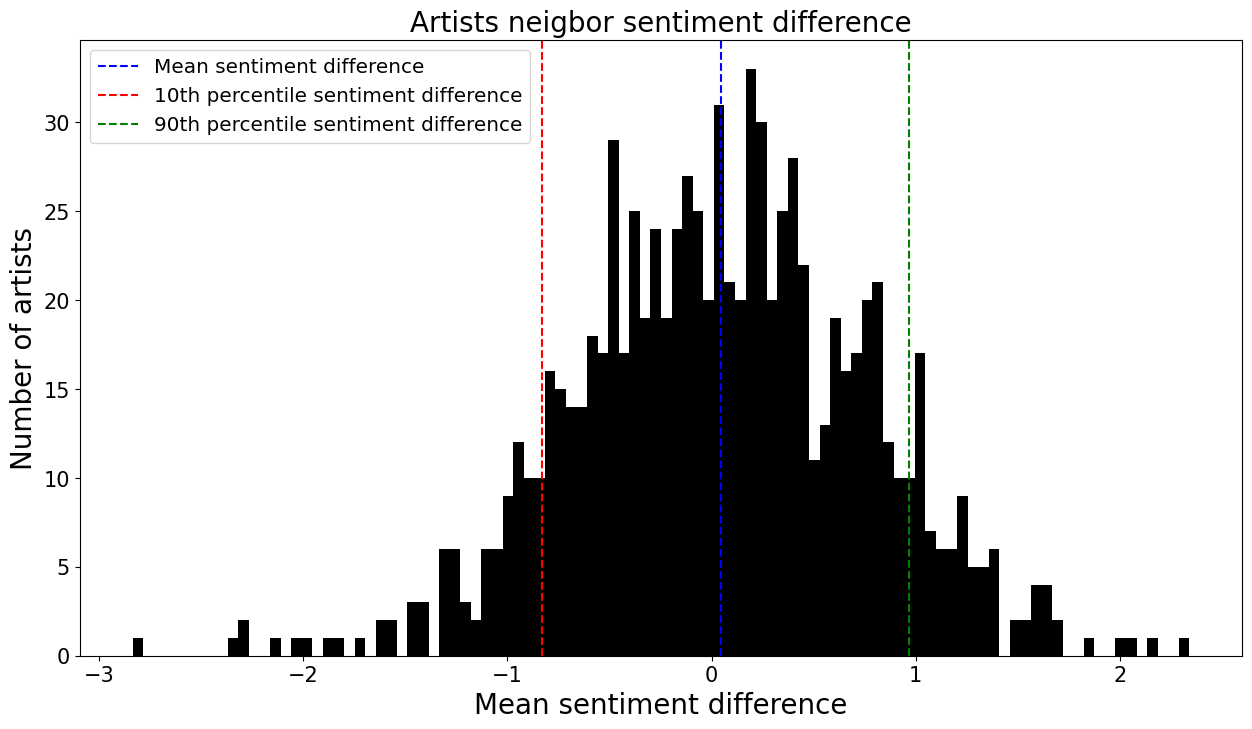

In [41]:
sentiment_diff = []
for artist in sentiment_artists_dict.keys():
    neighb = np.nanmean([sentiment_artists_dict[a] for a in artists_network.neighbors(artist) if a in sentiment_artists_dict.keys()])
    sentiment_diff.append(sentiment_artists_dict[artist] - neighb)

sentiment_diff = [x for x in sentiment_diff if str(x) != 'nan']
men = np.nanmean(sentiment_diff)
print(f'The mean sentiment difference is {"%.2f" % men}')
print(f'The 10th percentile sentiment difference is {"%.2f" % np.percentile(sentiment_diff, 10)}')
print(f'The 90th percentile sentiment difference is {"%.2f" % np.percentile(sentiment_diff, 90)}')
# cm = [a for a in plt.cm.get_cmap('Set1').colors]

plt.figure(figsize=(15,8), )
plt.hist(sentiment_diff, bins=100,color='black', orientation='vertical')
plt.axvline(x=men,linestyle='--',color='b', label='Mean sentiment difference')
plt.axvline(x=np.percentile(sentiment_diff, 10),linestyle='--',color='r', label='10th percentile sentiment difference')
plt.axvline(x=np.percentile(sentiment_diff, 90),linestyle='--',color='g', label='90th percentile sentiment difference')
plt.legend(fontsize="x-large")
plt.title("Artists neigbor sentiment difference", fontsize=20)
plt.ylabel("Number of artists", fontsize=20)
plt.xlabel("Mean sentiment difference", fontsize=20)
ax = plt.gca()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

### Not included in the final report

Comparison of total degree distribution with a Random Network and a Scale-Free Network of the same size.

Minimum degree: 1
Maximum degree: 49


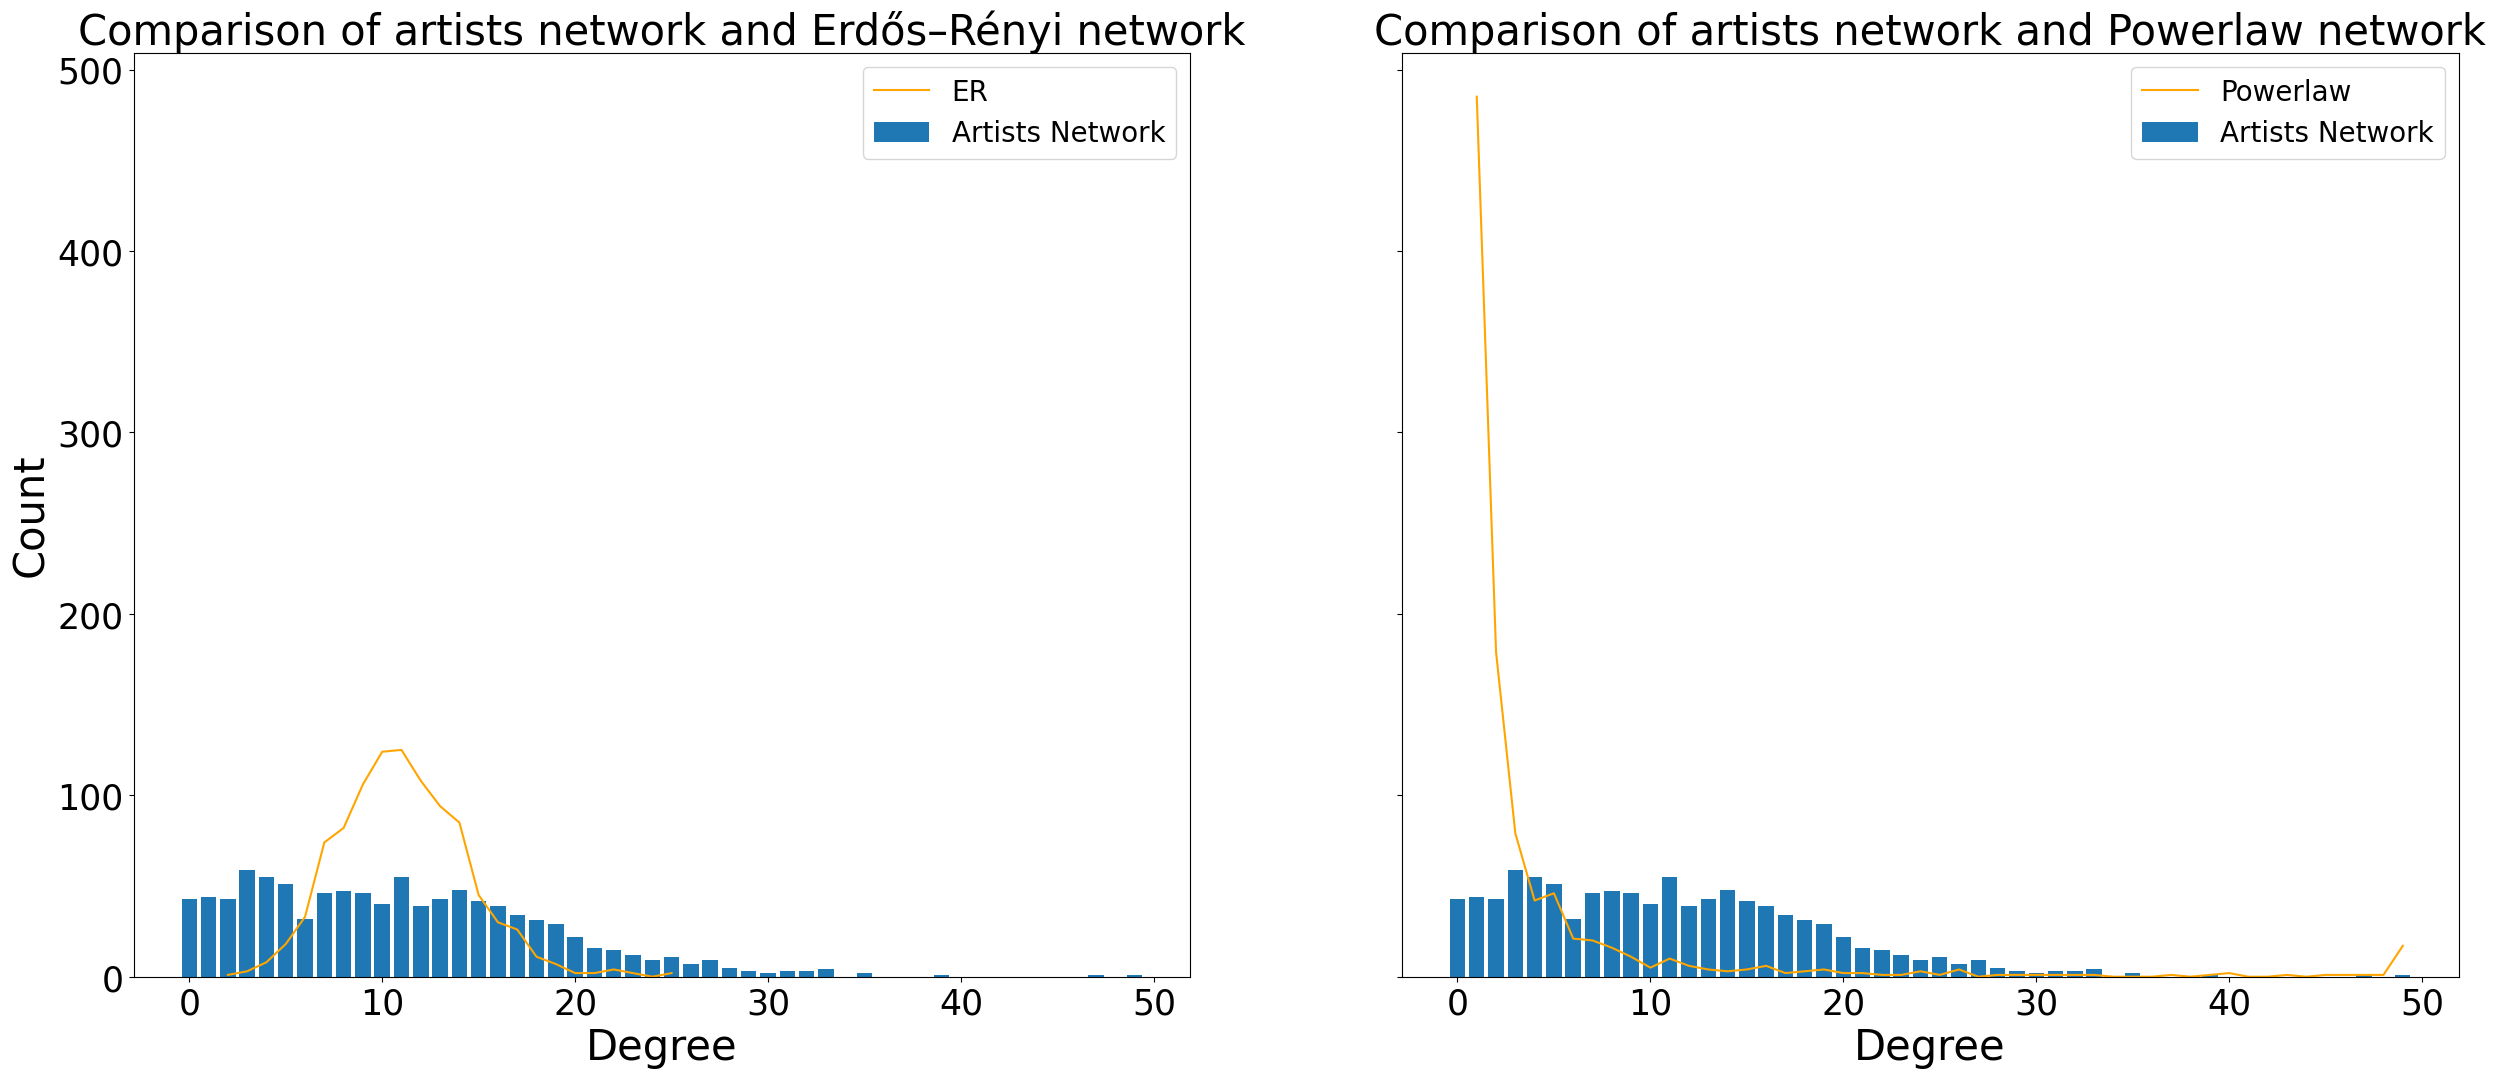

In [43]:
N = artists_network.number_of_nodes()
L = artists_network.number_of_edges()
p = 2 * L / (N * (N - 1))
ERG = nx.erdos_renyi_graph(N, p)

powerlaw_sequence = nx.utils.powerlaw_sequence(N, 2)

for i in range(0, N):
    powerlaw_sequence[i] = int(np.amin([powerlaw_sequence[i], np.max(degree_sequence)]))

if sum(powerlaw_sequence) % 2 != 0:
    random_n = np.random.choice(range(0, N))
    powerlaw_sequence[random_n] += 1

print("Minimum degree: " + str(np.amin(powerlaw_sequence)))
print("Maximum degree: " + str(np.amax(powerlaw_sequence)))

degree_graph = nx.configuration_model(powerlaw_sequence)
degree_sequence_pl = sorted((d for n, d in degree_graph.degree()))
v_pl = [*range(np.amin(degree_sequence_pl), np.amax(degree_sequence_pl) + 1)]
degree_distribution_pl = np.histogram(degree_sequence_pl,
                            bins=np.amax(degree_sequence_pl) - np.amin(degree_sequence_pl) + 1)

degree_er = sorted((d for n, d in ERG.degree()))
v_er = [*range(np.amin(degree_er), np.amax(degree_er) + 1)]
degree_distr_er = np.histogram(degree_er, bins=np.amax(degree_er) - np.amin(degree_er) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12), sharey=True)

ax1.bar(v, degree_distribution[0], label="Artists Network")
ax1.plot(v_er, degree_distr_er[0], label="ER", color='orange')
ax1.set_title("Comparison of artists network and Erdős–Rényi network", fontsize=30)
ax1.set_xlabel("Degree", fontsize=30)
ax1.set_ylabel("Count", fontsize=30)
ax1.legend(prop={'size': 20})
ax1.tick_params(axis='both', which='major', labelsize=25)

ax2.bar(v, degree_distribution[0], label="Artists Network")
ax2.plot(v_pl, degree_distribution_pl[0], label="Powerlaw", color='orange')
ax2.set_title("Comparison of artists network and Powerlaw network", fontsize=30)
ax2.set_xlabel("Degree", fontsize=30)
ax2.legend(prop={'size': 20})
ax2.tick_params(axis='both', which='major', labelsize=25)

plt.show()

Visualization of communities on USA-UK subnetwork.

In [44]:
nodes_usa_uk = [n for n in artists_network_undirected.nodes if \
    artists_network_undirected.nodes[n]["country"] == "United States" or
    artists_network_undirected.nodes[n]["country"] == "United Kingdom"]
usa_uk_network = artists_network_undirected.subgraph(nodes_usa_uk)

color_map_usa_uk = []
size_map_usa_uk = []

degrees = [degree for node, degree in usa_uk_network.degree()]

d_min = np.amin(degrees)
d_max = np.amax(degrees)

borders = {'actual': {'lower': d_min, 'upper': d_max}, 'desired': {'lower': 5, 'upper': 300}}
           
def normalize(value, bounds):
    return bounds['desired']['lower'] + (value - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower'])

communities = list(set(partition.values()))

N = len(communities)

colormap = plt.cm.nipy_spectral
colors = colormap(np.linspace(0, 1, N))

def cmap(n):
    return colors[n]

for artist in usa_uk_network.nodes():
    group = partition[artist]
    group_index = communities.index(group)
    color_map_usa_uk.append(cmap(group_index))
    size_map_usa_uk.append(normalize(usa_uk_network.degree(artist), borders))

100%|██████████| 2000/2000 [00:04<00:00, 417.06it/s]
Repulsion forces  took  3.78  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.47  seconds


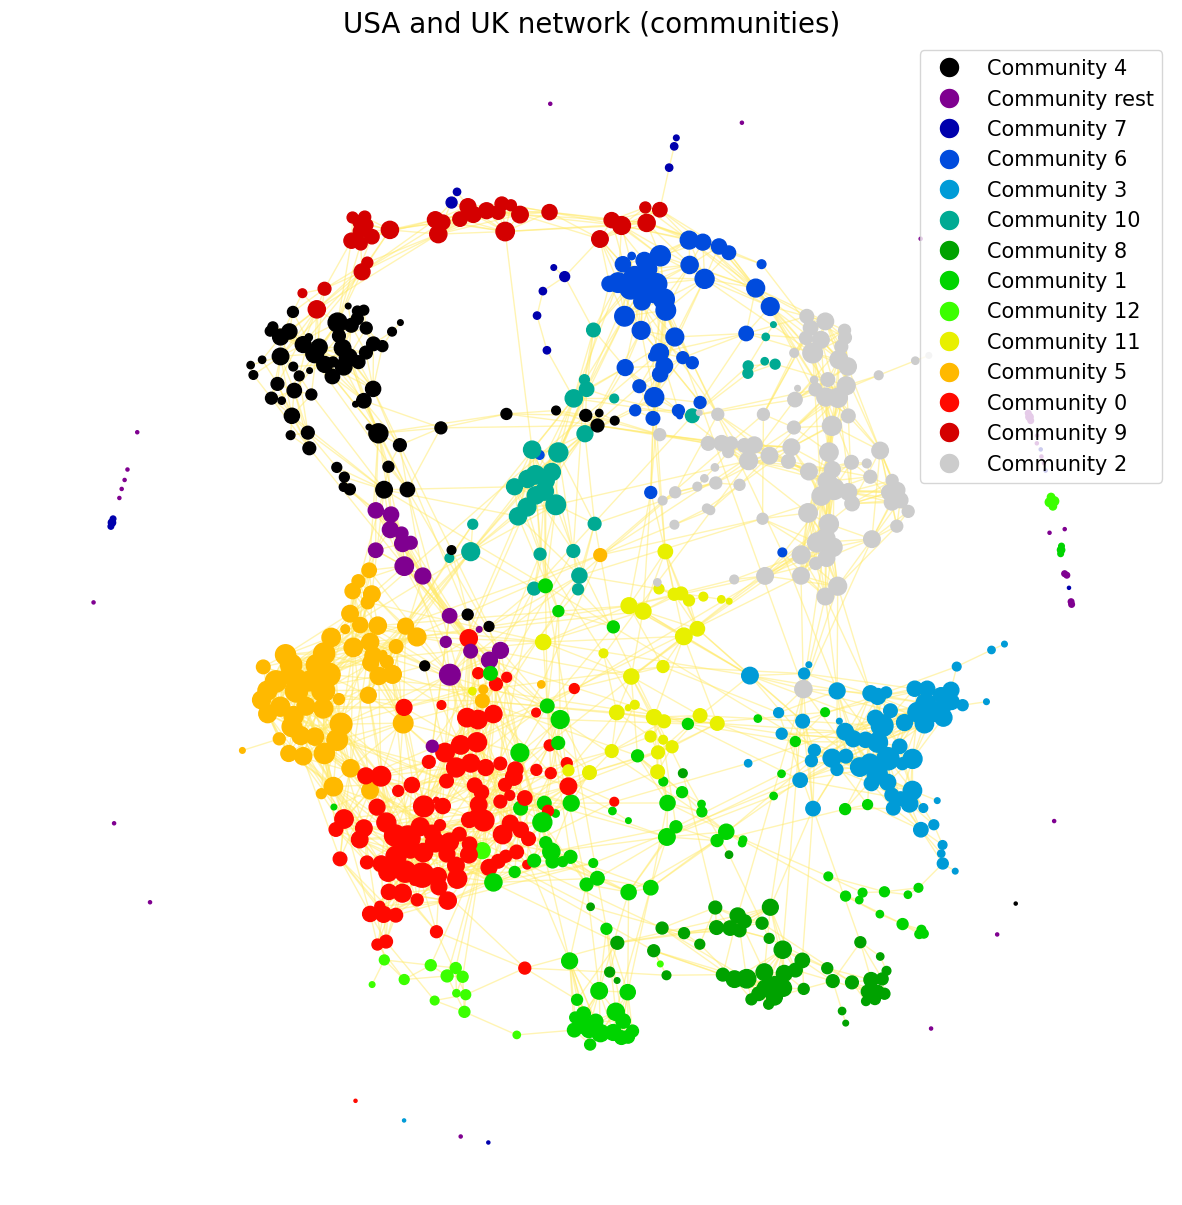

In [45]:
positions_usa_uk = forceatlas2.forceatlas2_networkx_layout(usa_uk_network, pos=None,
    iterations=2000)

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(usa_uk_network, positions_usa_uk, node_size=size_map_usa_uk,
    node_color=color_map_usa_uk)
nx.draw_networkx_edges(usa_uk_network, positions_usa_uk, edge_color="#FFEA68", alpha=0.5)
plt.axis('off')

legend_elements_usa_uk = []
for i, community in enumerate(communities):
    legend_elements_usa_uk.append(
        Line2D([0], [0], marker='o', color='w', label=community, markerfacecolor=cmap(i), markersize=15))

plt.title('USA and UK network (communities)', fontsize=20)
plt.legend(handles=legend_elements_usa_uk, loc='upper right', prop={'size': 15},
    fontsize=15)

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90e17496-b592-4f15-86da-4141fe902b95' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>